# RULE-BASED APPROACH
Student 1: Sara Martín (NIU:1669812)

Student 2: Amelia Gomez (NIU:1631745)

Student 3: Aina Navarro (NIU:1670797)

Student 4: Lara Rodríguez (NIU: 1667906)

## Functionalities

In [1]:
!git clone https://github.com/saraxmartin/NegExES.git
%cd "/content/NegExES"
!git pull

Cloning into 'NegExES'...
remote: Enumerating objects: 204, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 204 (delta 13), reused 2 (delta 2), pack-reused 169
Receiving objects: 100% (204/204), 3.64 MiB | 10.90 MiB/s, done.
Resolving deltas: 100% (107/107), done.
/content/NegExES
Already up to date.


In [ ]:
!pip install spacy
!pip install pyspellchecker
!pip install -U spacy
!pip install language-tool-python
!python -m spacy download es_core_news_sm
!pip install Levenshtein

In [3]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import unicodedata
import json
import spacy
import random
import xml.etree.ElementTree as ET
import nltk
nltk.download("punkt")
nltk.download('wordnet')
import string
import Levenshtein
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from spellchecker import SpellChecker
import language_tool_python
# Load the Spanish language model from spaCy
nlp = spacy.load("es_core_news_sm")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [4]:
def text_to_sentences(text):
    sent_text = nltk.sent_tokenize(text)
    return sent_text

def remove_punctuation(sentence):
    sentence_no_punct = sentence.translate(str.maketrans("", "", string.punctuation))
    return sentence_no_punct

def sentence_to_words(sentence):
    tokenized_sentence = nltk.word_tokenize(sentence)
    return tokenized_sentence

def join_sentence(words):
    sentence = ""
    for i, word in enumerate(words):
        if i == 0:
            sentence += word
        else:
            sentence += " " + word
    return sentence

In [5]:
def correct_mispellings(words, language):
    # Initialize a spell checker for Spanish
    corrected_words = []
    if language=="es":
      with language_tool_python.LanguageToolPublicAPI('es') as tool:
        for word in words:
          corrected = tool.correct(word)
          corrected_words.append(corrected.lower())
    elif language=="cat":
      with language_tool_python.LanguageToolPublicAPI('ca-ES') as tool:
        for word in words:
          corrected = tool.correct(word)
          corrected_words.append(corrected.lower())

    return corrected_words

def correct_mispelling_normal_word(word):
  spell = SpellChecker(language='es')

  if word in spell: # if there is NOT a mispelling
    return word
  else:
    correct_word = spell.correction(word)
    return correct_word

def correct_mispelling(word, medicalterms):
  spell = SpellChecker(language='es')

  if len(word) == 1:
      if word in spell: # if there is NOT a mispelling
        return word
      else: # if the word is not in spell
        if word in medicalterms:
          return word
        else:

          # find the closest word of w in medicalterms
          best = ""
          max = 0
          for term in medicalterms:
            temporal = Levenshtein.distance(word, term)
            if max < temporal:
              max = temporal
              best = term
          correct_word = spell.correction(word)
          print(f"{word} should be spell:{correct_word}, distance:{best}")
          return best

  else: # the entered word consist of more than one word
    list_words = word.split() # splitting the input for each word
    original = ""
    for w in list_words: # iterating through all the words
        if w in spell: # if there is NOT a mispelling
          original += w + " "
        else: # if word not in spellchecker
          if w in medicalterms: # if word in medicalterms
            original += w + " "
          else: # the word is a mispelling

            # find the closest word of w in medicalterms
            best = ""
            max = 0
            for term in medicalterms:
              for t in term:
                temporal = Levenshtein.distance(word, t)
                if max < temporal:
                  max = temporal
                  best = term
            correct_word = spell.correction(word)
            print(f"{w} should be spell:{correct_word}, distance:{best}")
            original += best + " "

    return original

def lemmatize(words):
  lemmatizer = WordNetLemmatizer()
  lemmatized_words = []
  for word in words:
    lemmatized_words.append(lemmatizer.lemmatize(word))

  return lemmatized_words

def stem(words):
  ps = PorterStemmer()
  stem_words = []
  for word in words:
    stem_words.append(ps.stem(word))

  return stem_words

def has_letters(word):
    for char in word:
        if char.isalpha():
            return True
    return False

def remove_punctuation(word):
    if not has_letters(word):
        return word
    new_word =""
    for char in word:
        if char.islower():
            new_word += char
    return new_word

In [6]:
def visualize_text_with_highlights(words,labels):
    # Plot the text with highlights
    plt.figure(figsize=(12, 1))
    plt.axis('off')

    line_counter = 0
    words_per_line = 0

    for i, word in enumerate(words):
        if words_per_line == 5:
            line_counter += 1
            words_per_line = 0

        x = words_per_line * 0.6
        y = -line_counter * 0.5

        if labels[i] == "NEG":
            plt.text(x,y, word, fontsize=20, color='black', va='center', ha='left', backgroundcolor='yellow')
        elif labels[i] == "NSCO":
            plt.text(x,y, word, fontsize=20, color='black', va='center', ha='left', backgroundcolor='green')
        elif labels[i] == "UNC":
            plt.text(x,y, word, fontsize=20, color='black', va='center', ha='left', backgroundcolor='blue')
        elif labels[i] == "USCO":
            plt.text(x,y, word, fontsize=20, color='black', va='center', ha='left', backgroundcolor='pink')
        else:
            plt.text(x,y, word, fontsize=20, color='black', va='center', ha='left', backgroundcolor='white')

        words_per_line +=1

    plt.show()

# Data pre-processing


#### Import the data (JSON), create training and test datasets and create list of trigger words (negations and uncertainity words)


In [7]:
train_data_path = "/content/NegExES/data/negacio_train_v2024.json"
test_data_path = "/content/NegExES/data/negacio_test_v2024.json"

# Read files
with open(train_data_path, 'r') as file:
    train_json_data = file.read()
    train_data = json.loads(train_json_data)

with open(test_data_path, 'r') as file:
    test_json_data = file.read()
    test_data = json.loads(test_json_data)

# Initialize lists
neg, unc, medicalterms = [],[],[]

def extract_data(data, train=False):
    """
    Extracts the data from the JSON file.
    Returns:
        corpus: list of texts
        ground_truth: list of dictionaries (one for each text)
            with the true labels for negations/uncertainities and
            their scopes.
    """
    corpus = []
    ground_truth = []
    for item in data:
        text = item['data']['text']
        corpus.append(text)
        predictions = item['predictions']
        text_gt = {"NEG":[],"UNC":[],"NSCO":[],"USCO":[]}
        for prediction in predictions:
            for result in prediction['result']:
                value = result['value']
                start = value['start']
                end = value['end']
                labels = value['labels']
                extracted_text = text[start:end]
                for label in labels:
                    if (label == "NEG") and (extracted_text not in neg) and train:
                          neg.append(extracted_text)
                    elif (label == "UNC") and (extracted_text not in unc) and train:
                          unc.append(extracted_text)
                    elif ((label == "NSCO") or (label == "USCO")) and (extracted_text not in medicalterms) and train:
                          medicalterms.append(extracted_text)
                    text_gt[label].append((start,end))

            ground_truth.append(text_gt)

    return corpus, ground_truth

x_train, gt_train = extract_data(train_data, train=True)
x_test, gt_test = extract_data(test_data, train=False)

print("Length negations:", len(neg))
print("Length uncertainty:", len(unc))
print("Length medical terms:", len(medicalterms))
print("Length training data:", len(x_train))
print("Length test data:", len(x_test))

Length negations: 98
Length uncertainty: 84
Length medical terms: 2955
Length training data: 254
Length test data: 64


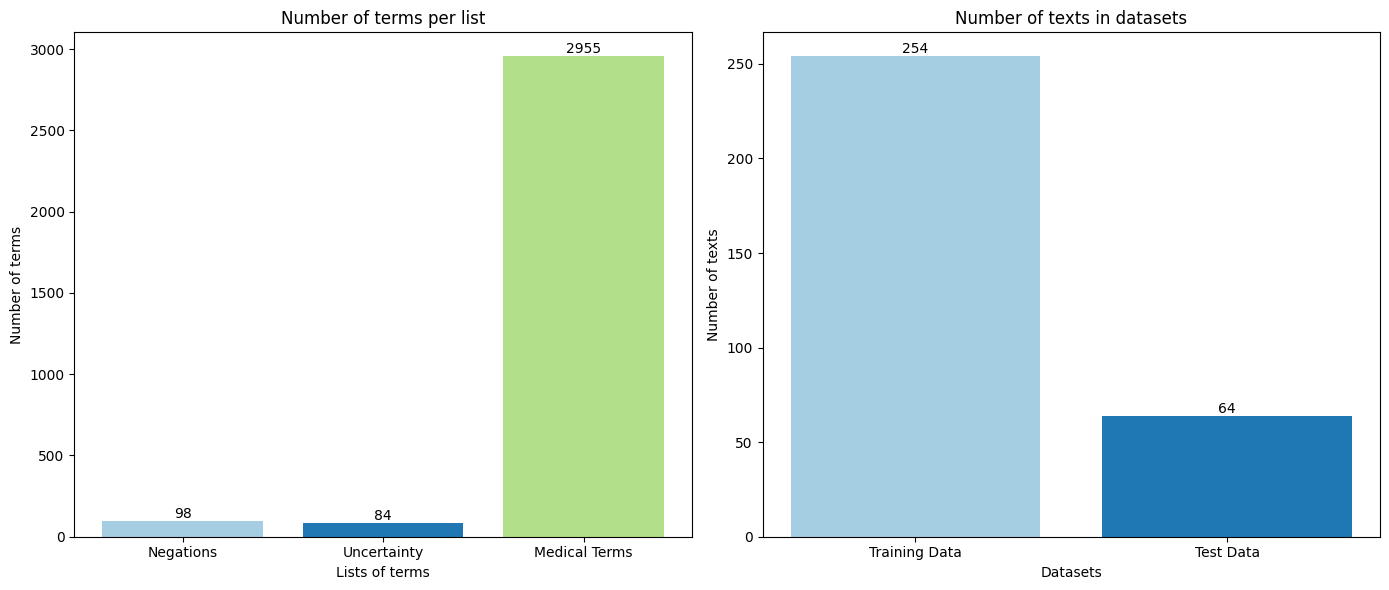

In [8]:
# Visualization of datasets
colors = sns.color_palette("Paired",4)

# Plot 1: Number of terms per list
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
data_plot = [len(neg), len(unc), len(medicalterms)]
bars = plt.bar(['Negations', 'Uncertainty', 'Medical Terms'], data_plot, color=colors)
plt.xlabel('Lists of terms')
plt.ylabel('Number of terms')
plt.title('Number of terms per list')
for bar, number in zip(bars, data_plot):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05, str(number), ha='center', va='bottom')

# Plot 2: Number of texts in datasets
plt.subplot(1, 2, 2)
data_plot = [len(x_train), len(x_test)]
bars = plt.bar(['Training Data', 'Test Data'], data_plot, color=colors)
plt.xlabel('Datasets')
plt.ylabel('Number of texts')
plt.title('Number of texts in datasets')
for bar, number in zip(bars, data_plot):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05, str(number), ha='center', va='bottom')

plt.tight_layout()
plt.show()



In [9]:
# Create y_train and y_test from gt_train and gt_test

def get_token_indices(text):
    tokens = nltk.word_tokenize(text)
    indices = []
    current_index = 0
    for token in tokens:
        start = text.find(token, current_index)
        end = start + len(token)
        indices.append((start, end))
        current_index = end
    return tokens, indices

def is_within_indices(index,indices_list):
    for idx in indices_list:
        if idx[0] <= index[0] <= idx[1] and idx[0] <= index[1] <= idx[1]:
            return True
    return False

def create_y_data(text_indices,gt):
    y_data = []
    for index in text_indices:
        if is_within_indices(index,gt["NEG"]):
            y_data.append("NEG")
        elif is_within_indices(index,gt["UNC"]):
            y_data.append("UNC")
        elif is_within_indices(index,gt["NSCO"]):
            y_data.append("NSCO")
        elif is_within_indices(index,gt["USCO"]):
            y_data.append("USCO")
        else:
            y_data.append("O")
    return y_data

X_train_tokens = []
X_train_tokenindex = []
y_train = []
for i,text in enumerate(x_train):
    text_tokens, text_indices = get_token_indices(text)
    X_train_tokenindex.append(text_indices)
    X_train_tokens.append(text_tokens)
    y_data = create_y_data(text_indices,gt_train[i])
    y_train.append(y_data)

X_test_tokens = []
X_test_tokenindex = []
y_test = []
for i,text in enumerate(x_test):
    text_tokens, text_indices = get_token_indices(text)
    X_test_tokenindex.append(text_indices)
    X_test_tokens.append(text_tokens)
    y_data = create_y_data(text_indices,gt_test[i])
    y_test.append(y_data)

In [10]:
for word,label in zip(X_train_tokens[0][170:300],y_train[0][170:300]):
    print(f"{word} - {label}")

realiza - O
cistoscopia - NSCO
que - O
es - O
negativa - NEG
para - NSCO
lesiones - NSCO
malignas - NSCO
pero - O
se - O
objetiva - O
estenosis - O
de - O
uretra - O
. - O
se - O
intentan - O
dilataciones - O
progresivas - O
en - O
el - O
gabinete - O
de - O
urologia - O
sin - NEG
exito - NSCO
. - NSCO
se - O
solicita - O
estudio - O
de - O
imagen - O
que - O
confirma - O
la - O
existencia - O
de - O
estenosis - O
a - O
nivel - O
d - O
uretra - O
bulbar - O
por - O
lo - O
que - O
se - O
indica - O
uretrtomia - O
interna - O
. - O
exploracio - O
complementaria - O
uretrocistografia - O
retrograda - O
+ - O
cums - O
( - O
11/2017 - O
) - O
: - O
la - O
uretrografia - O
retrograda - O
muestra - O
una - O
uretra - O
anterior - O
con - O
dos - O
estenosis - O
focales - O
a - O
nivel - O
de - O
uretra - O
peneana - O
y - O
bulbar - O
, - O
aunque - O
se - O
observa - O
paso - O
de - O
contraste - O
retrogrado - O
a - O
vejiga - O
. - O
vejiga - O
de - O
correcta - O
capacidad - O
( - O
250 -

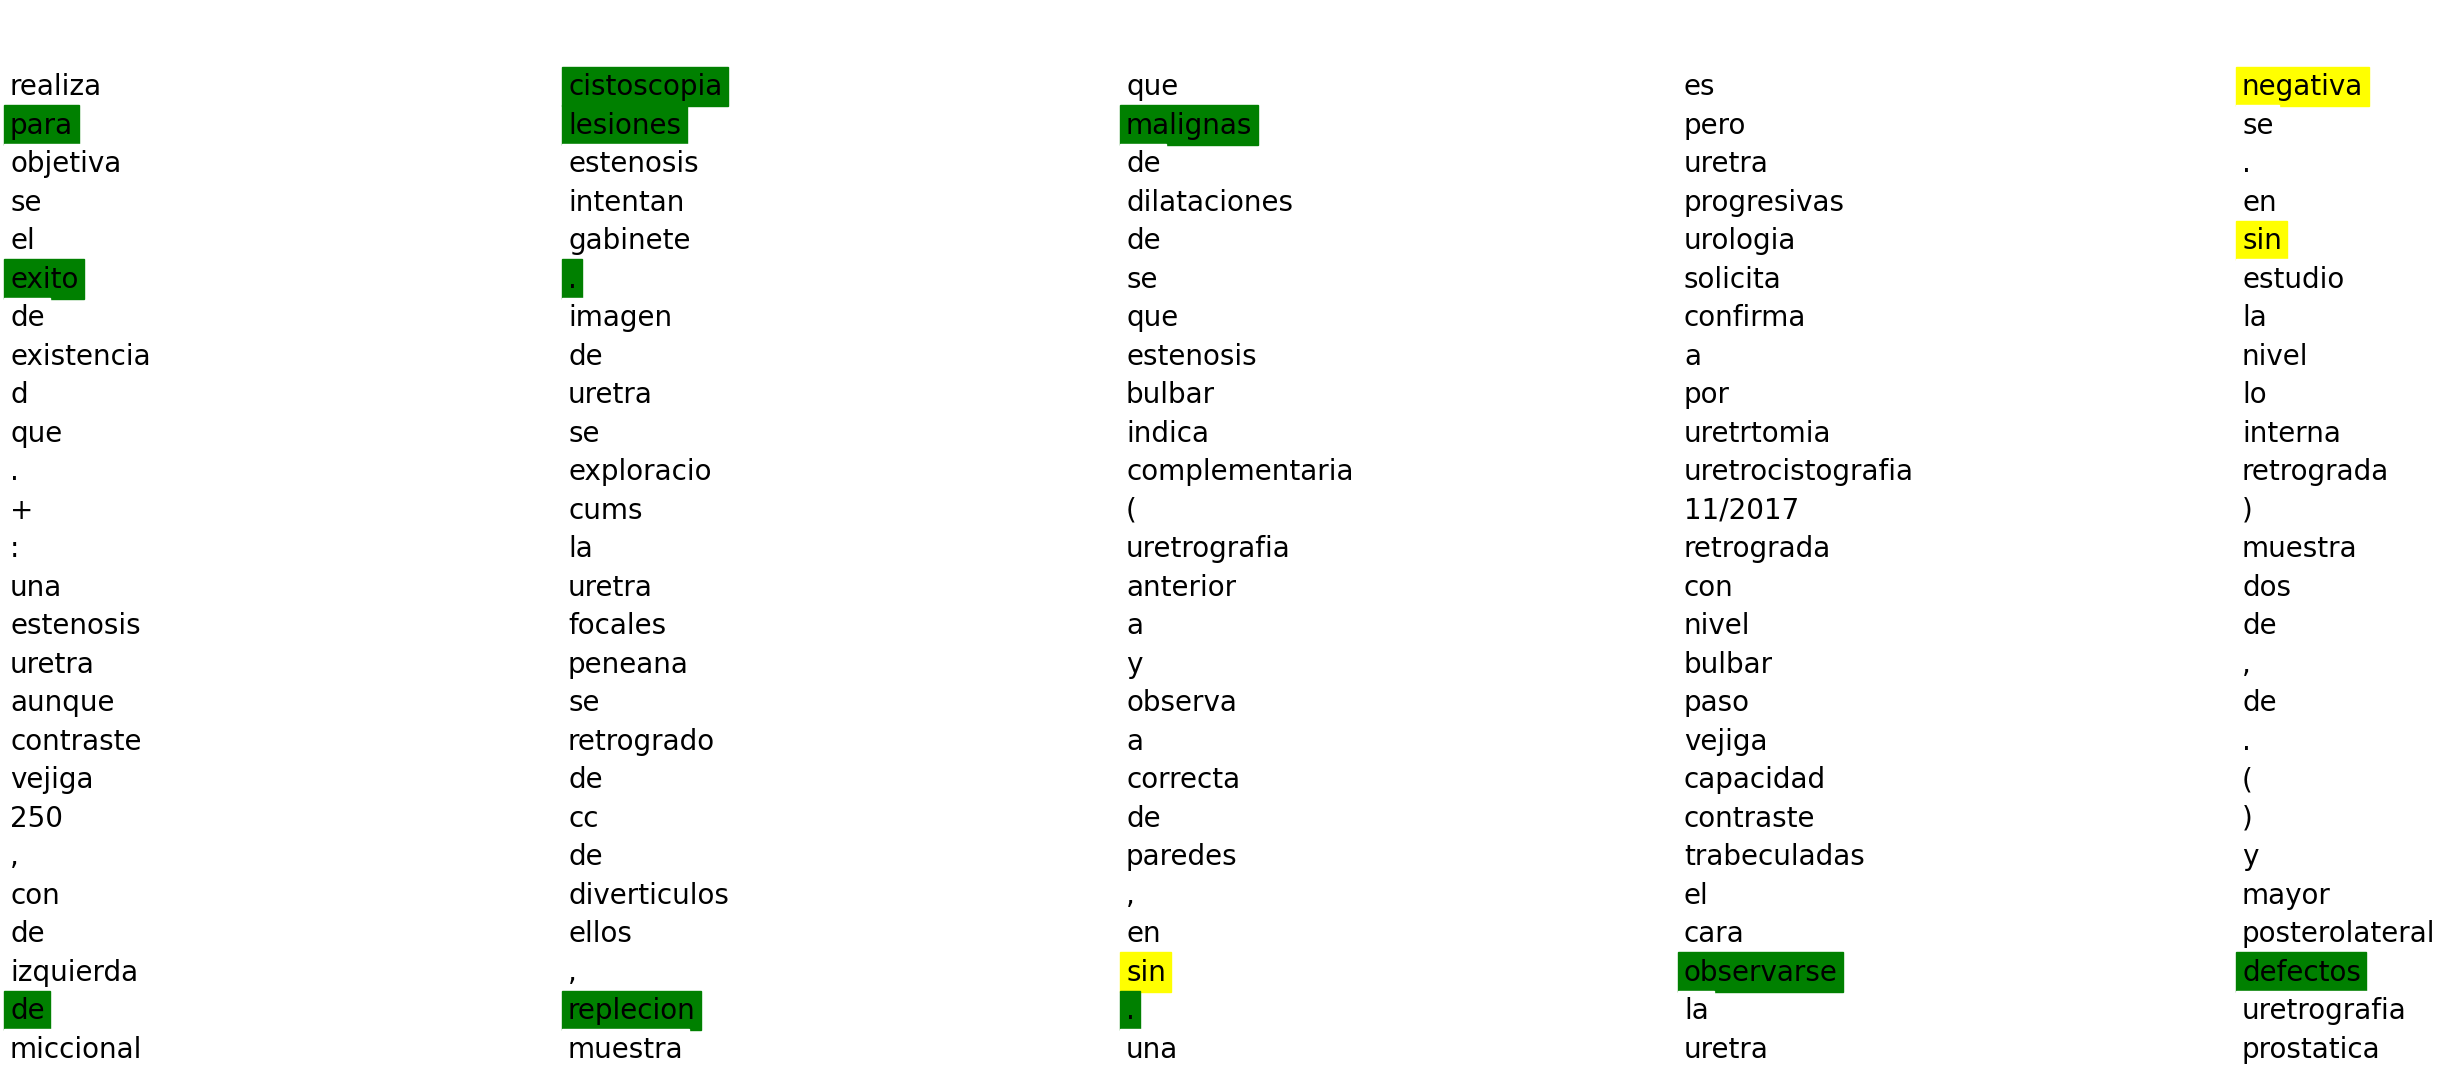

In [11]:
# Visualization
visualize_text_with_highlights(X_train_tokens[0][170:300],y_train[0][170:300])

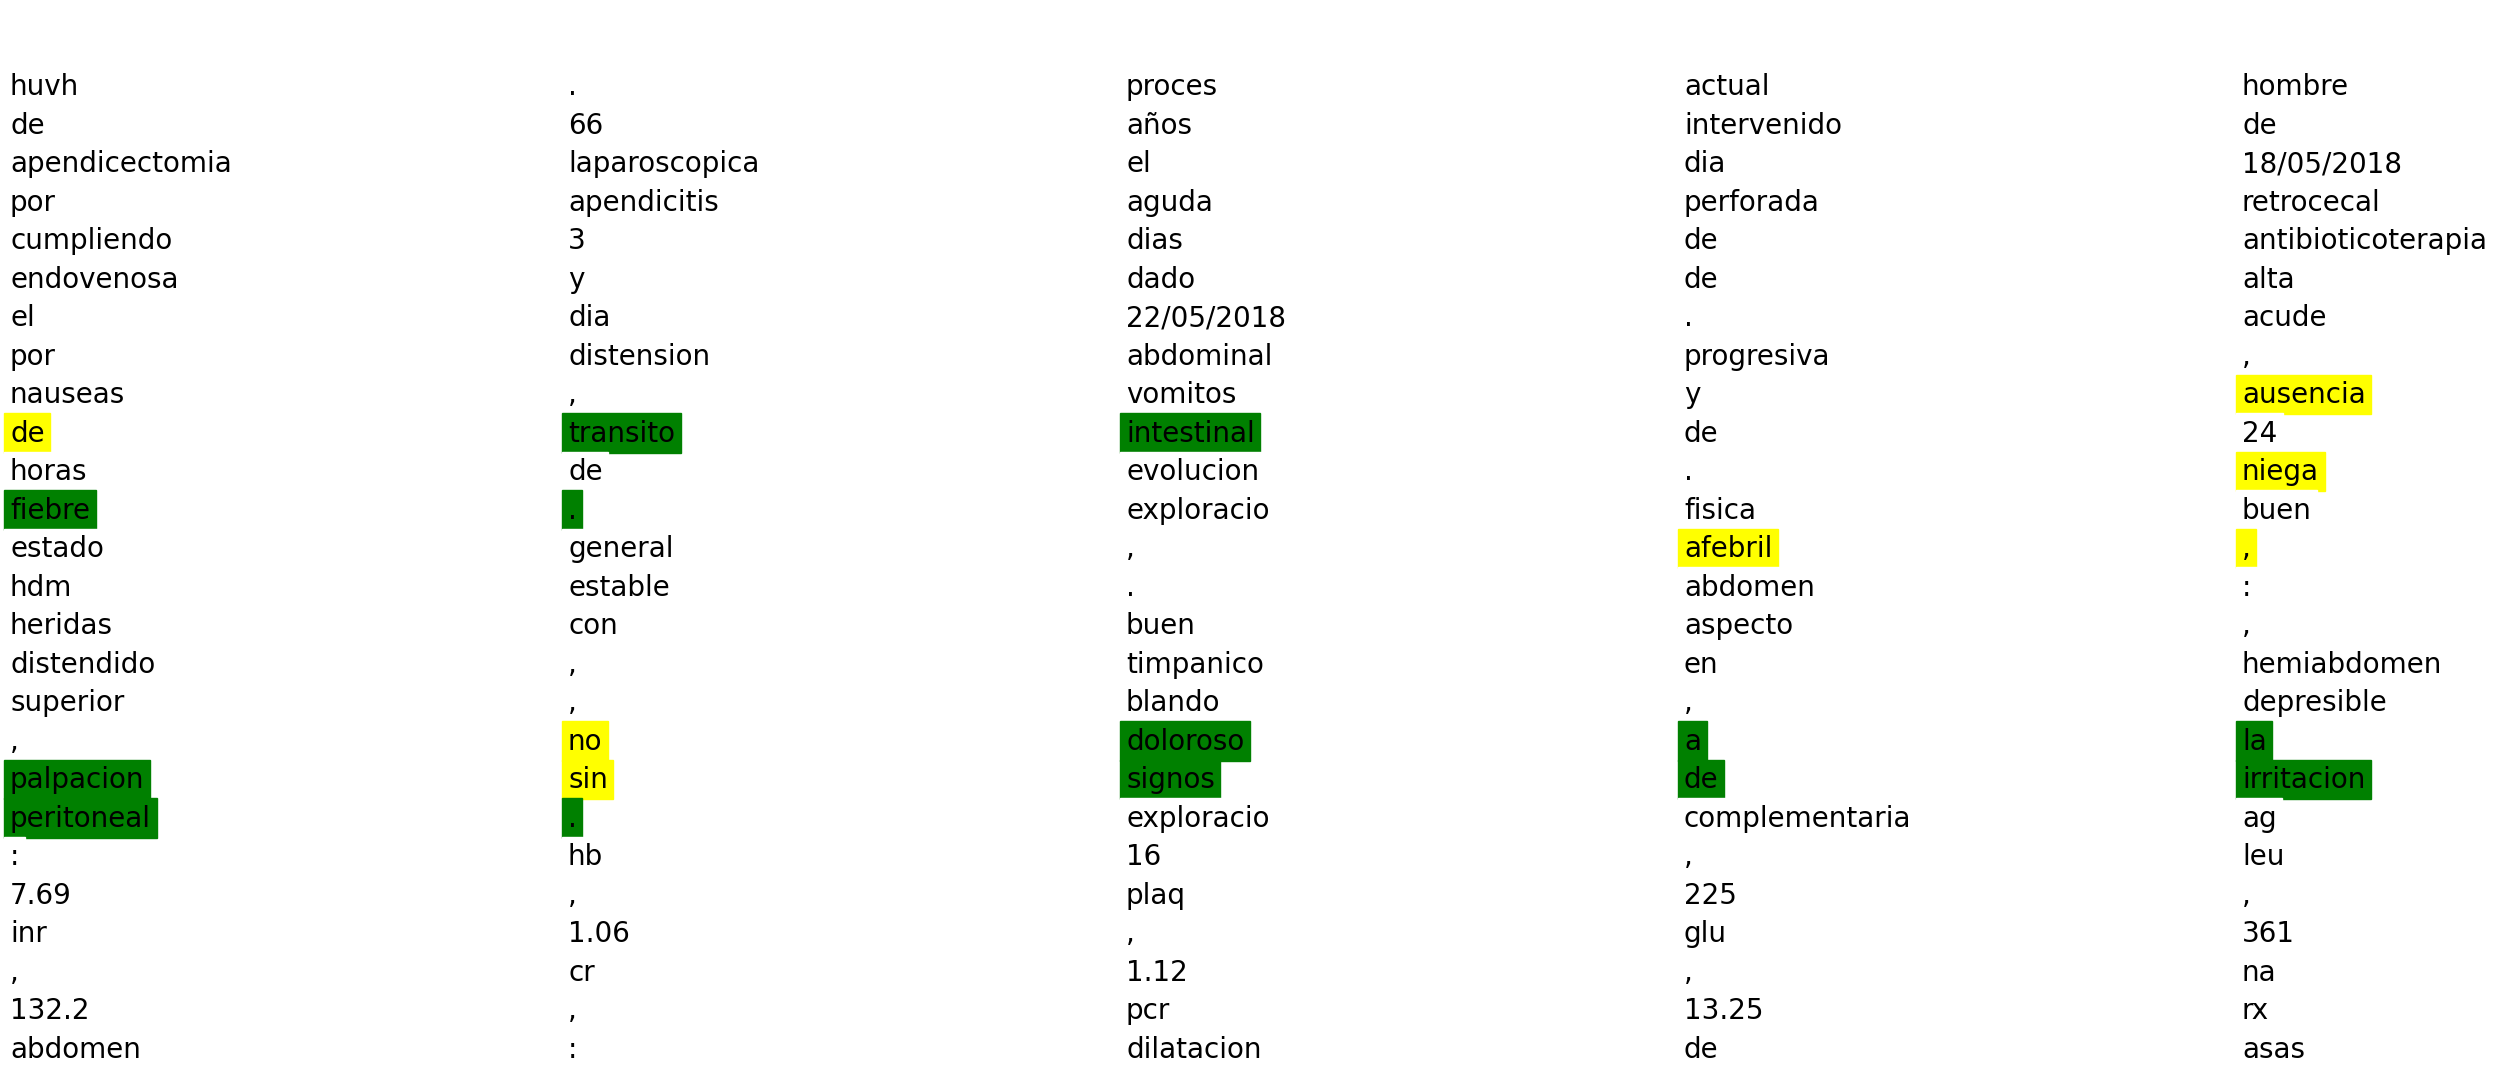

In [12]:
visualize_text_with_highlights(X_train_tokens[2][170:300],y_train[2][170:300])

#### Add extra negation and uncertainity words

In [13]:
# Add rule tags we found to the ones we have from the training dataset
neg_path = "/content/NegExES/data/neg-phrases.txt"
postneg_path = "/content/NegExES/data/post-neg-phrases.txt"
pseudoneg_path = "/content/NegExES/data/pseudo-neg-phrases.txt"
conj_path = "/content/NegExES/data/conjunctions.txt"
unc_path = "/content/NegExES/data/unc-phrases.txt"

def extract_rules(file_path):
  words = []
  with open(file_path, 'r') as file:
    for _ in range(3):
      next(file)
    for line in file:
      if line.startswith(":"):
          break
      words.append(line.strip('\n'))
  return list(set(words))

more_neg = extract_rules(neg_path)
more_neg.extend(extract_rules(postneg_path))
more_neg.extend(extract_rules(pseudoneg_path))
more_unc = extract_rules(unc_path)
conj = extract_rules(conj_path)

# Store intial length for comparison
initial_len_neg = len(neg)
print("Initial length of negation list:",len(neg))
initial_len_unc = len(unc)
print("Initial length of uncertainties list: ",len(unc))

# Extract negations that aren't in neg already
more_neg = [word for word in more_neg if word not in neg ]
neg.extend(more_neg)
more_unc = [word for word in more_unc if word not in unc]
unc.extend(more_unc)
print("Length updated negations:", len(neg))
print("Length updated uncertainties:", len(unc))
print("Length of conjunction words:", len(conj))

Initial length of negation list: 98
Initial length of uncertainties list:  84
Length updated negations: 258
Length updated uncertainties: 264
Length of conjunction words: 56


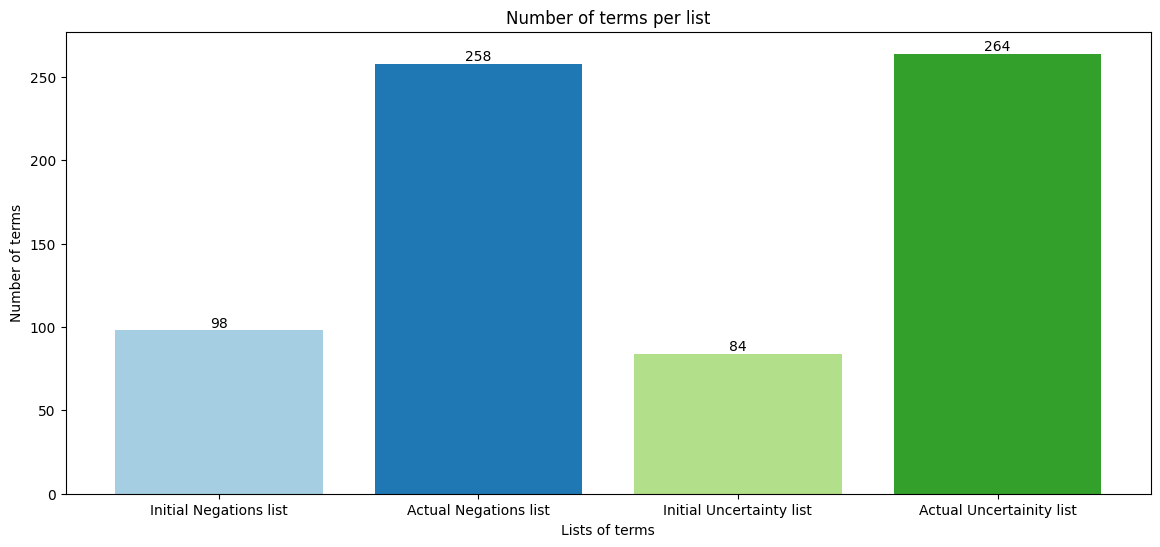

In [14]:
# Visualization of datasets
colors = sns.color_palette("Paired",4)

plt.figure(figsize=(14, 6))
data_plot = [initial_len_neg, len(neg), initial_len_unc, len(unc)]
bars = plt.bar(['Initial Negations list','Actual Negations list', 'Initial Uncertainty list', 'Actual Uncertainity list'], data_plot, color=colors)
plt.xlabel('Lists of terms')
plt.ylabel('Number of terms')
plt.title('Number of terms per list')
for bar, number in zip(bars, data_plot):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05, str(number), ha='center', va='bottom')

#### Add extra medical terminology

In [15]:
medicalterms_es = set()
medicalterms_cat = set()

directory = '/content/NegExES/data/termcat_terminologies'

for filename in os.listdir(directory):
    if filename.endswith('.xml'):
        # Construct the full path to the XML file
        file_path = os.path.join(directory, filename)

        # Parse the XML file
        tree = ET.parse(file_path)
        root = tree.getroot()

        # Iterate over each 'fitxa' element
        for fitxa in root.findall('.//fitxa'):
            # Iterate over each 'denominacio' element within the 'fitxa'
            for denominacio in fitxa.findall('denominacio'):
                if denominacio.get('llengua') == 'es':
                    if denominacio.text not in medicalterms_es:
                        medicalterms_es.add(denominacio.text)
                elif denominacio.get('llengua') == 'ca':
                    if denominacio.text not in medicalterms_cat:
                        medicalterms_cat.add(denominacio.text)

medicalterms_es = list(medicalterms_es)
medicalterms_cat = list(medicalterms_cat)

initial_len_medterms = len(medicalterms)

print("Length medical terms in spanish:", len(medicalterms_es))
print("Length medical terms in catalan:", len(medicalterms_cat), "\n")
print("Some medical terms in spanish", medicalterms_es[:20])
print("Some medical terms in catalan", medicalterms_cat[:20], "\n")

medicalterms = medicalterms_es + medicalterms_cat
print("Total amount of medical terms", len(medicalterms))

Length medical terms in spanish: 17052
Length medical terms in catalan: 17394 

Some medical terms in spanish ['otitis adhesiva', 'VN', 'VPH-4', 'seudartrosis', 'célula de Schultze', 'droga', 'septicemia', 'ventrículo cardíaco', 'memoria a largo plazo', 'corpúsculo de Meissner', 'visión borrosa', 'RRR', 'movimiento', 'resonancia magnética espectroscópica', 'iridonco', 'dacriocistalgia', 'hiperexpresión', 'miastenia grave', 'sustancia gelatinosa de Rolando', 'aprendizaje discriminativo']
Some medical terms in catalan ['otitis adhesiva', 'cèl·lula', 'apòfisi vocal del cartílag aritenoide', 'fòrnix vaginal', 'artefacte', 'estria vascular del conducte coclear', 'VN', 'osteopatia hiperostòsica esclerosant', 'lligament timpanomal·leal', 'ciliarotomia', 'isogènic -a', 'aturada del pensament', 'tubercle de Santorini', 'droga', 'fàscia perineal superficial', 'múscul erector dels pèls', 'abducció', 'nucli del nervi accessori', 'verola', 'múscul tensor del vel del paladar'] 

Total amount of medi

In [16]:
# Add extra medical terms
medical_keywords = ['resultado','efecto','reacción','prueba','respuesta','diagnóstico','presencia','hallazgo','función','riesgo','síntoma','indicación','tratamiento','terapia',
                    'análisis','complicación','enfermedad','condición','sensibilidad','exposición''concentración','infección','detección','alteración','nivel','signo','deficiencia',
                    'intolerancia','inmunidad','resistencia','capacidad','absorción','secuela','progresión','mejora','rechazo','eficacia','toxicidad','prevención']

for word in medical_keywords:
    if word not in medicalterms:
        medicalterms.append(word)

print("Total amount of medical terms updated", len(medicalterms))

Total amount of medical terms updated 34457


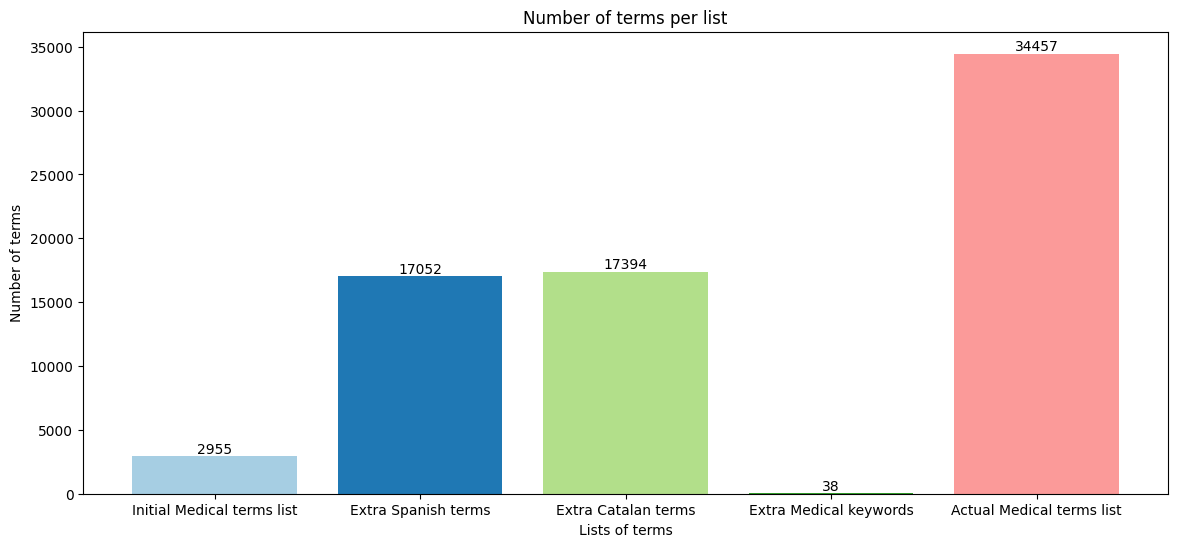

In [17]:
# Visualization of datasets
colors = sns.color_palette("Paired",5)

plt.figure(figsize=(14, 6))
data_plot = [initial_len_medterms, len(medicalterms_es), len(medicalterms_cat), len(medical_keywords), len(medicalterms)]
bars = plt.bar(['Initial Medical terms list','Extra Spanish terms', 'Extra Catalan terms', 'Extra Medical keywords', 'Actual Medical terms list'], data_plot, color=colors)
plt.xlabel('Lists of terms')
plt.ylabel('Number of terms')
plt.title('Number of terms per list')
for bar, number in zip(bars, data_plot):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05, str(number), ha='center', va='bottom')

### Preprocess Rule Tags

In [18]:
def remove_accents(word):
    # Decompose the word into its base characters and accents
    normalized_word = unicodedata.normalize('NFD', word)
    # Remove accents by filtering out non-combining characters
    stripped_word = ''.join(char for char in normalized_word if unicodedata.category(char) != 'Mn')
    return stripped_word

def convert_to_regex(word_list):
    regex_list = [rf"\b{re.escape(word)}\b" for word in word_list]
    return regex_list

In [19]:
# Clean rules
def clean_words(words):
    words = [word.strip("!?,.;:") for word in words]
    words = [word.rstrip() for word in words]
    words = lemmatize(words)
    words = [remove_accents(word) for word in words]
    words = list(set(words))
    return words

neg = clean_words(neg)
unc = clean_words(unc)
medicalterms = clean_words(medicalterms)
conj = clean_words(conj)

print("Updated length of negations:", len(neg))
print("Some examples of negations:", neg[:50])
print("Updated length of uncertainties:", len(unc))
print("Some examples of uncertainties:", unc[:50])
print("Length of the amount of medical terms we have:", len(medicalterms))
print("Some examples of medical terms:", medicalterms[:50])
print("Updated length of conjunctions:", len(conj))
print("Some examples of conjunctions:", conj[:50])

Updated length of negations: 221
Some examples of negations: ['retiro', 'expulso al paciente por', 'no revela', 'desaparicion del', 'adecuado para descartarla', 'sin dificultad', 'sin cambios sospechosos', 'estan descartadas', 'debe descartarse', 'desorientado', 'descartaron contra', 'no poder', 'descartaron al paciente por', 'imposibilidad de', 'sin indicacion de', 'debe ser descartado', 'sin hallazgos de', 'suficiente para descartarlo', 'suficiente para descartarla en contra', 'no sentir', 'adecuado para descartar al paciente por', 'se suspende', 'en ninguna', 'sera descartado por', 'hacer una prueba por', 'sera descartado', 'tengo dudas', 'nunca tuve', 'ningun cambio significativo', 'sin quejas de', 'suficiente para descartarlo en contra', 'puede descartar al paciente contra', 'tampoco', 'sin signos de', 'sin cambio definitivo', 'mas bien que', 'puede descartarlo en contra', 'inestabilidad', 'puede descartar', 'cambio de intervalo no significativo', 'afebril', 'negativo', 'negativa)

In [20]:
# Check if there are repeated elements in both lists
common_elements = set(neg) & set(unc)
print(common_elements)

# Delete repeted elements from one of the lists
unc = [word for word in unc if word not in neg]
print("Updated lenght of uncertainities:",len(unc))

{'sin', 'no', 'descartar'}
Updated lenght of uncertainities: 246


In [21]:
# Check if there are elements with spaces in lists
words_with_spaces_neg = [word for word in neg if word.strip() != word]
print(words_with_spaces_neg)
words_with_spaces_unc = [word for word in unc if word.strip() != word]
print(words_with_spaces_unc)

neg = [word for word in neg if word not in words_with_spaces_neg]

[' afebril', ' negativo', ' no']
[]


In [22]:
# Convert to regex format
neg_regex = convert_to_regex(neg)
unc_regex = convert_to_regex(unc)
medicalterms_regex = convert_to_regex(medicalterms)
conj_regex = convert_to_regex(conj)

print("Some examples of negations:", neg_regex[:50])
print("Some examples of uncertainties:", unc_regex[:50])
print("Some examples of medical terms:", medicalterms_regex[:50])
print("Some examples of conjunctions:", conj_regex[:50])

Some examples of negations: ['\\bretiro\\b', '\\bexpulso\\ al\\ paciente\\ por\\b', '\\bno\\ revela\\b', '\\bdesaparicion\\ del\\b', '\\badecuado\\ para\\ descartarla\\b', '\\bsin\\ dificultad\\b', '\\bsin\\ cambios\\ sospechosos\\b', '\\bestan\\ descartadas\\b', '\\bdebe\\ descartarse\\b', '\\bdesorientado\\b', '\\bdescartaron\\ contra\\b', '\\bno\\ poder\\b', '\\bdescartaron\\ al\\ paciente\\ por\\b', '\\bimposibilidad\\ de\\b', '\\bsin\\ indicacion\\ de\\b', '\\bdebe\\ ser\\ descartado\\b', '\\bsin\\ hallazgos\\ de\\b', '\\bsuficiente\\ para\\ descartarlo\\b', '\\bsuficiente\\ para\\ descartarla\\ en\\ contra\\b', '\\bno\\ sentir\\b', '\\badecuado\\ para\\ descartar\\ al\\ paciente\\ por\\b', '\\bse\\ suspende\\b', '\\ben\\ ninguna\\b', '\\bsera\\ descartado\\ por\\b', '\\bhacer\\ una\\ prueba\\ por\\b', '\\bsera\\ descartado\\b', '\\btengo\\ dudas\\b', '\\bnunca\\ tuve\\b', '\\bningun\\ cambio\\ significativo\\b', '\\bsin\\ quejas\\ de\\b', '\\bsuficiente\\ para\\ descartarlo\\ en\

### Preprocess Corpus

In [23]:
# Split corpus in sentences + tokenize to lemmatize + join words in sentences again
def preprocess_corpus(corpus):
    """
    Input: corpus: list of lists containing texts
    Output: texts: list of sentences of each text with words preprocessed
    """
    texts = []
    for text in corpus:
        sentences = []
        offset = 0
        # Separate text in sentences
        text_sent = nltk.sent_tokenize(text) # this gives us a list of sentences

        for sentence in text_sent:
            words = nltk.word_tokenize(sentence)
            words = [word.lower() for word in words]
            words = lemmatize(words)
            words = [remove_accents(word) for word in words]
            words = [remove_punctuation(word) for word in words] #doesn't remove punctuation symbols alone
            new_sentence = join_sentence(words)
            sentences.append(new_sentence)

        texts.append(sentences)

    return texts

In [24]:
corpus_example = ["-Puede que tenga dolor- mucho. El cielo hoy estaba azul! Que bonito. Por cierto, como estas? Tienes sangre ahí que fuerte","No me digas.", "que no lo sabes? vaya"]
corpus_cleaned = preprocess_corpus(corpus_example)
print(corpus_cleaned) # Lo separa por sentences --> good

corpus_example = ["edad: 42 años tpal: 1001 (eutocico) fur: 21.12.2019 sg: 40+0. gsrh:a+ gestacion controlada en alto riesgo obstetrico (aro) por antecedente de depresion postparto + diabetes gestacional"]
corpus_cleaned = preprocess_corpus(corpus_example)
print(corpus_cleaned) # Lo coge todo como una sentence -> good

[['puede que tenga dolor mucho .', 'el cielo hoy estaba azul !', 'que bonito .', 'por cierto , como estas ?', 'tienes sangre ahi que fuerte'], ['no me digas .'], ['que no lo sabes ?', 'vaya']]
[['edad : 42 anos tpal : 1001 ( eutocico ) fur : 21.12.2019 sg : 40+0 .', 'gsrh : a gestacion controlada en alto riesgo obstetrico ( aro ) por antecedente de depresion postparto + diabetes gestacional']]


In [25]:
X_train = preprocess_corpus(x_train)
X_test = preprocess_corpus(x_test)

### Data status

#### What we have until now:

- neg / neg_regex: list of negation words / regex format
- unc / unc_regex: list of uncertainity words / regex format
- conj / conj_regex: list of conjunction words / regex format
- medicalterms / medicalterms_regex: list of medical terms / regex format
- x_train/x_test: list of texts
- X_train_tokens/X_test_tokens: list of words of each text
- X_train_tokenindex/X_test_tokenindex: list of tuples of indices for each word in text
- y_train/y_test: list of true labels for each word in text

#### What we want to obtain:
- y_pred_train/y_pred_test: list of predicted labels for each word in text

# NegEx algorithm implementation

## Model #1 - negex tagger: scope is whole sentence

In [27]:
# IMPORT THE TAGGER
py_path = '/content/NegExES/medical_report_tagger.py'

import importlib.util
spec = importlib.util.spec_from_file_location("MedicalReportTagger", py_path)
module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(module)
MedicalReportTagger = module.MedicalReportTagger

In [28]:
# Create an instance of the MedicalReportTagger class
tagger = MedicalReportTagger(neg_regex, unc_regex,conj, medicalterms)

y_pred_train_m1 = []
for item in train_data:
    text = item["data"]["text"]
    # Run the tagger on the text
    results = tagger.tag_negation_and_uncertainty(text)
    pred = {'NEG':[],'UNC':[],'NSCO':[],'USCO':[]}
    for dic in results:
        start = dic['value']['start']
        end = dic['value']['end']
        label = dic['value']['labels'][0]
        pred[label].append((start,end))

    text_tokens, text_indices = get_token_indices(text)
    pred_labels = create_y_data(text_indices,pred)
    y_pred_train_m1.append(pred_labels)

In [29]:
tagger = MedicalReportTagger(neg_regex, unc_regex,conj, medicalterms)

y_pred_test_m1 = []
for item in test_data:
    text = item["data"]["text"]
    # Run the tagger on the text
    results = tagger.tag_negation_and_uncertainty(text)
    pred = {'NEG':[],'UNC':[],'NSCO':[],'USCO':[]}
    for dic in results:
        start = dic['value']['start']
        end = dic['value']['end']
        label = dic['value']['labels'][0]
        pred[label].append((start,end))

    text_tokens, text_indices = get_token_indices(text)
    pred_labels = create_y_data(text_indices,pred)
    y_pred_test_m1.append(pred_labels)

## Model #2 - using regular expressions

In [30]:
def tags_scopes(all_indices,tag_start,med_start):
    tag_index, med_index = None,None
    for idx in all_indices:
        if idx[0] == tag_start:
            tag_index = idx
        elif idx[0] == med_start:
            med_index = idx

    #Handling errors--------------
    if (tag_index == None) or (med_index == None):
        return None,None

    return tag_index, med_index

def order_tags(tag_start,med_start):
    if tag_start < med_start:
        order = 1
    elif tag_start > med_start:
        order = 2
    return order

def find_scope(all_indices,tag_index,med_index,order):
    if order == 1:
        start = all_indices.index(tag_index) + 1
        end = all_indices.index(med_index)
        scope_indices = all_indices[start:end+1]
    elif order == 2:
        start = all_indices.index(med_index)
        end = all_indices.index(tag_index)
        scope_indices = all_indices[start:end]
    return scope_indices

def indices_to_labels(sentence,indices,tag=None):
    """
    Returns list of labels for each word in the sentence
    """
    labels = []

    # Get all (start,end) indices of all words in sentence
    tokens, all_indices = get_token_indices(sentence)

    # Get indices of scope
    scope_indices = []
    tag_indices = []
    for index_tuple in indices[tag]:
        tag_index, med_index = tags_scopes(all_indices,index_tuple[0],index_tuple[1])

        #Handling errors--------------
        if (tag_index == None) and (med_index == None):
            print("tokens",tokens)
            print("all indices",all_indices)
            print("tag index",tag_index)
            print("med index",med_index)
            labels = ["O" for _ in range(len(all_indices))]
            print("labels:",labels)
            return labels

        order = order_tags(index_tuple[0],index_tuple[1])
        tag_indices.append(tag_index)
        scope_indices.extend(find_scope(all_indices,tag_index,med_index,order))

    # Append the labels
    for idx in all_indices:
        if idx in tag_indices:
            labels.append(tag)
        elif idx in scope_indices:
            if tag == "NEG":
                labels.append("NSCO")
            elif tag == "UNC":
                labels.append("USCO")
        else:
            labels.append("O")

    return labels

def join_labels(neg_labels,unc_labels):
    joined_labels = []
    for eneg, eunc in zip(neg_labels,unc_labels):
        if eneg == eunc:
            joined_labels.append(eneg)
        else:
            if eneg == "O":
                joined_labels.append(eunc)
            elif eunc == "O":
                joined_labels.append(eneg)
            else:
                joined_labels.append(eneg+"/"+eunc)
    return joined_labels


def tagger(text, neg, unc, medterms):
    """
    Detect negations/uncertainties and their scopes in texts from a corpus.
    Input:
        text: list of sentences (preprocessed text)
        neg: list of negation words
        unc: list of uncertainity words
        medterms: list of medical terms
    Output:
        labels: predicted labels for each word in the text
    """
    labels = []
    pattern_neg = re.compile(r'\b(' + '|'.join(neg) + r')\b\s+(?:\w+\s*){0,5}\b(' + '|'.join(medterms) + r')\b|\b(' + '|'.join(medterms) + r')\b\s+(?:\w+\s*){0,5}\b(' + '|'.join(neg) + r')\b')
    pattern_unc = re.compile(r'\b(' + '|'.join(unc) + r')\b\s+(?:\w+\s*){0,5}\b(' + '|'.join(medterms) + r')\b|\b(' + '|'.join(medterms) + r')\b\s+(?:\w+\s*){0,5}\b(' + '|'.join(unc) + r')\b')

    for sentence in text:
        indices = {"NEG":[],"UNC":[]}
        # Find negation matches
        for match in pattern_neg.finditer(sentence):
            neg_index = match.start(1) if match.group(1) else match.start(4)
            med_index = match.start(2) if match.group(2) else match.start(3)
            indices["NEG"].append((neg_index,med_index))

        # Obtain negation and negation scopes
        neg_labels = indices_to_labels(sentence,indices,tag="NEG")

        # Find uncertainty matches
        for match in pattern_unc.finditer(sentence):
            unc_index = match.start(1) if match.group(1) else match.start(4)
            med_index = match.start(2) if match.group(2) else match.start(3)
            indices["UNC"].append((unc_index,med_index))

        # Obtain uncertainity and uncertainity scopes
        unc_labels = indices_to_labels(sentence,indices,tag="UNC")

        # Create and store sentence labels
        labels_sent = join_labels(neg_labels,unc_labels)
        labels.extend(labels_sent)

    return labels


In [31]:
text_example = ['un ataque al corazon puede ser','puede ser un ataque al corazon que fuerte','antecedents no tiene alergia a penicilina y cloramfenicol .', 'tampoco fiebre.', 'fiebre tampoco.', 'se realiza cistoscopia que es negativo para lesiones malignas pero se objetiva estenosis de uretra .']
labels_example =tagger(text_example, neg_regex, unc_regex, medicalterms_regex)
print(labels_example)

['O', 'USCO', 'USCO', 'USCO', 'UNC', 'O', 'UNC', 'USCO', 'USCO', 'USCO', 'USCO', 'USCO', 'O', 'O', 'O', 'NEG', 'NSCO', 'NSCO', 'O', 'O', 'O', 'O', 'O', 'NEG', 'NSCO', 'O', 'NSCO', 'NEG', 'O', 'O', 'O', 'O', 'O', 'O', 'NEG', 'NSCO', 'NSCO', 'NSCO', 'NSCO', 'NSCO', 'NSCO', 'NSCO', 'O', 'O', 'O']


In [ ]:
y_pred_train_m2 = []

i=0
for text in X_train:
    predicted_labels = tagger(text, neg_regex, unc_regex, medicalterms_regex)
    y_pred_train_m2.append(predicted_labels)
    i+=1
    print(i)

In [ ]:
y_pred_test_m2 = []

i=0
for text in X_test:
    predicted_labels = tagger(text, neg_regex, unc_regex, medicalterms_regex)
    y_pred_test_m2.append(predicted_labels)
    i+=1
    print(i)

## Model #3 - using dependency parsing

In [34]:
def dependency_scope(sentence, tag):
  doc = nlp(sentence)
  scope = []
  scope_i = []

  if len(tag.split())!=1:
    tag = tag.split()[0]

  # We will consider the head of the 'neg' or 'unc' tag as the root
  for token in doc:
      #print("{2}({3}-{6}, {0}-{5})".format(token.text, token.tag_, token.dep_, token.head.text, token.head.tag_, token.i, token.head.i))
      if token.text == tag:
        root = token.head.text
        root_index = token.head.i

  for token in doc:
      # Take the words which depend on the root (avoid replicated words)
      if token.dep_=='conj': # some medical terms are wrongly labeled as VB
        if token.text not in medicalterms:
          break
      if token.head.text == root and token.head.i == root_index:
        # Constituent which depends on the root
        scope.append(token.text)
        scope_i.append(token.i)
      if token.text == root and token.i == root_index and token.dep_!='conj':
        scope.append(token.head.text)
        scope_i.append(token.head.i)


  while True:
    ini_len = len(list(set(scope)))
    for token in doc:
      # Take the words which depend on words that depend on the root (avoid replicated words)
      if token.head.text != root and token.head.i != root_index:
        if token.head.text in scope and token.head.i in scope_i:
            scope.append(token.text)
            scope_i.append(token.i)
    if len(list(set(scope)))==ini_len:
      break

  # Sort the scope
  sentence_words = sentence.split()
  word_index = {word: sentence_words.index(word) for word in sentence_words}
  sorted_scope = sorted(list(set(scope)), key=lambda x: word_index.get(x, len(sentence_words)))

  return sorted_scope

In [35]:
def dependency_tagger(text, neg, unc, medterms):
    """
    Detect negations/uncertainties and their scopes in texts from a corpus.
    Input:
        text: list of sentences (preprocessed text)
        neg: list of negation words
        unc: list of uncertainity words
        medterms: list of medical terms
    Output:
        labels: predicted labels for each word in the text
    """
    labels = []
    pattern_neg = re.compile(r'\b(' + '|'.join(neg) + r')\b\s+(?:\w+\s*){0,5}\b(' + '|'.join(medterms) + r')\b|\b(' + '|'.join(medterms) + r')\b\s+(?:\w+\s*){0,5}\b(' + '|'.join(neg) + r')\b')
    pattern_unc = re.compile(r'\b(' + '|'.join(unc) + r')\b\s+(?:\w+\s*){0,5}\b(' + '|'.join(medterms) + r')\b|\b(' + '|'.join(medterms) + r')\b\s+(?:\w+\s*){0,5}\b(' + '|'.join(unc) + r')\b')

    for sentence in text:
        indices = {"NEG":[],"UNC":[]}
        tokens, all_indices = get_token_indices(sentence)

        # Find negation matches
        neg_labels=['O']*len(all_indices)
        for match in pattern_neg.finditer(sentence):
            neg_index = match.start(1) if match.group(1) else match.start(4)
            med_index = match.start(2) if match.group(2) else match.start(3)
            neg_match = match.group(1) if match.group(1) else match.group(4)
            neg_match = neg_match.strip()

            dep_scope = dependency_scope(sentence, neg_match)

            for i,idx in enumerate(all_indices):
              if len(neg_match.split())==1:
                if sentence[idx[0]:idx[1]] == neg_match:
                  neg_labels[i] = 'NEG'
                elif sentence[idx[0]:idx[1]] in dep_scope:
                  neg_labels[i] = 'NSCO'
                else:
                  neg_labels[i] = 'O'
              else:
                if sentence[idx[0]:idx[1]] in neg_match:
                  prev_neg = sentence[all_indices[i - 1][0]:all_indices[i - 1][1]] if i > 0 else None
                  next_neg = sentence[all_indices[i + 1][0]:all_indices[i + 1][1]] if i < len(all_indices) - 1 else None

                  if (prev_neg and prev_neg in neg_match) or (next_neg and next_neg in neg_match):
                      neg_labels[i] = 'NEG'
                  elif sentence[idx[0]:idx[1]] in dep_scope:
                      neg_labels[i] = 'NSCO'
                  else:
                      neg_labels[i] = 'O'
                elif sentence[idx[0]:idx[1]] in dep_scope:
                    neg_labels[i] = 'NSCO'
                else:
                    neg_labels[i] = 'O'


        # Find uncertainty matches
        unc_labels=['O']*len(all_indices)
        for match in pattern_unc.finditer(sentence):
            unc_index = match.start(1) if match.group(1) else match.start(4)
            med_index = match.start(2) if match.group(2) else match.start(3)
            unc_match = match.group(1) if match.group(1) else match.group(4)
            unc_match = unc_match.strip()

            dep_scope = dependency_scope(sentence, unc_match)

            for i,idx in enumerate(all_indices):
              if len(unc_match.split())==1:
                if sentence[idx[0]:idx[1]] == unc_match:
                  unc_labels[i] = 'UNC'
                elif sentence[idx[0]:idx[1]] in dep_scope:
                  unc_labels[i] = 'USCO'
                else:
                  unc_labels[i] = 'O'
              else:
                if sentence[idx[0]:idx[1]] in unc_match:
                  prev_unc = sentence[all_indices[i - 1][0]:all_indices[i - 1][1]] if i > 0 else None
                  next_unc = sentence[all_indices[i + 1][0]:all_indices[i + 1][1]] if i < len(all_indices) - 1 else None

                  if (prev_unc and prev_unc in unc_match) or (next_unc and next_unc in unc_match):
                      unc_labels[i] = 'UNC'
                  elif sentence[idx[0]:idx[1]] in dep_scope:
                      unc_labels[i] = 'USCO'
                  else:
                      unc_labels[i] = 'O'
                elif sentence[idx[0]:idx[1]] in dep_scope:
                    unc_labels[i] = 'USCO'
                else:
                    unc_labels[i] = 'O'


        # Create and store sentence labels
        labels_sent = join_labels(neg_labels,unc_labels)
        labels.extend(labels_sent)

    return labels

In [ ]:
y_pred_train_m3 = []

i=0
for text in X_train:
    predicted_labels = dependency_tagger(text, neg_regex, unc_regex, medicalterms_regex)
    y_pred_train_m3.append(predicted_labels)
    i+=1
    print(i)

In [ ]:
y_pred_test_m3 = []

i=0
for text in X_test:
    predicted_labels = dependency_tagger(text, neg_regex, unc_regex, medicalterms_regex)
    y_pred_test_m3.append(predicted_labels)
    i+=1
    print(i)

# Rule-based method Evaluation

In [ ]:
import numpy as np
from itertools import chain
import pandas as pd
from tabulate import tabulate
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, accuracy_score

In [52]:
#y_pred_test_m2[26] = y_pred_test_m2[26][:-2]

In [53]:
#y_pred_test_m3[26] = y_pred_test_m3[26][:-2]

In [54]:
# Check if y_true and y_pred are of the same lenght

n_texts_train = len(X_train)
n_texts_test = len(X_test)

def check_lenght(y_true,y_pred,n_texts):
    count=0
    for sublist1, sublist2 in zip(y_true,y_pred):
        if len(sublist1) == len(sublist2):
            count+=1
    if count == n_texts:
        print("Hooray! Both lists are aligned.")
    else:
        print("Lists are not aligned.")

print("Checking for model 1:")
check_lenght(y_train,y_pred_train_m1,n_texts=n_texts_train)
check_lenght(y_test,y_pred_test_m1,n_texts=n_texts_test)

print("Checking for model 2:")
check_lenght(y_train,y_pred_train_m2,n_texts=n_texts_train)
check_lenght(y_test,y_pred_test_m2,n_texts=n_texts_test)

print("Checking for model 3:")
check_lenght(y_train,y_pred_train_m3,n_texts=n_texts_train)
check_lenght(y_test,y_pred_test_m3,n_texts=n_texts_test)

Checking for model 1:
Hooray! Both lists are aligned.
Hooray! Both lists are aligned.
Checking for model 2:
Hooray! Both lists are aligned.
Hooray! Both lists are aligned.
Checking for model 3:
Hooray! Both lists are aligned.
Hooray! Both lists are aligned.


In [55]:
def encode_labels(y):
    new_y = []
    for element in y:
        if element == "O":
            new_y.append(0)
        elif element == "NEG":
            new_y.append(1)
        elif element == "NSCO":
            new_y.append(2)
        elif element == "UNC":
            new_y.append(3)
        elif element == "USCO":
            new_y.append(4)
        else:
            new_y.append(0)

    if len(y) == len(new_y):
        return new_y
    else:
        return None

def plot_metrics(report_df, title):
    report_df = report_df.drop(columns=['support'])

    report_melted = report_df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Value')
    report_melted.rename(columns={'index': 'Class'}, inplace=True)

    min_value = report_melted['Value'].min()

    sns.set(style='whitegrid')
    plt.figure(figsize=(12, 8))

    # Create the barplot
    ax = sns.barplot(data=report_melted, x='Class', y='Value', hue='Metric', palette='Paired')

    # Set y-axis limits
    plt.ylim(min_value-0.01, 1)

    # Add labels and title
    plt.xlabel('Class')
    plt.ylabel('Value')
    plt.title(f'Model{title} Classification Report')

    # Rotate x labels if needed
    plt.xticks(rotation=45)

    # Show the plot
    plt.show()

def evaluate(y_true,y_pred,num_model,dataset):
    # Flatten both lists
    y_true = [item for row in y_true for item in row]
    y_pred = [item for row in y_pred for item in row]

    # Check if lists are of the same lenght
    if not (len(y_true) == len(y_pred)):
        print("Error: lists are not of same lenght")
        return None

    # Change categorical labels to numerical for evaluation
    y_true_encoded = encode_labels(y_true)
    y_pred_encoded = encode_labels(y_pred)

    if (y_true_encoded == None) or (y_pred_encoded == None):
        print("Error: something went wrong while encoding.")
        return None

    # Compute metrics
    report = classification_report(y_true_encoded, y_pred_encoded, output_dict=True)
    df_report = pd.DataFrame(report).transpose()

    print(f"\nModel {num_model} evaluation for {dataset} dataset:")
    print(tabulate(df_report, headers='keys', tablefmt='grid'))

    # Plot metrics
    plot_metrics(df_report,num_model)

    return df_report

Results of model 1:


Model 1 evaluation for train dataset:
+--------------+-------------+----------+------------+---------------+
|              |   precision |   recall |   f1-score |       support |
+==============+=============+==========+============+===============+
| 0            |    0.991015 | 0.904815 |   0.945955 | 224531        |
+--------------+-------------+----------+------------+---------------+
| 1            |    0.798514 | 0.999336 |   0.887709 |   4517        |
+--------------+-------------+----------+------------+---------------+
| 2            |    0.503281 | 0.83921  |   0.629216 |  13981        |
+--------------+-------------+----------+------------+---------------+
| 3            |    0.463598 | 0.809942 |   0.589675 |    684        |
+--------------+-------------+----------+------------+---------------+
| 4            |    0.160941 | 0.824494 |   0.269313 |   2074        |
+--------------+-------------+----------+------------+---------------+
| accuracy     |    0.901878 | 0.90187

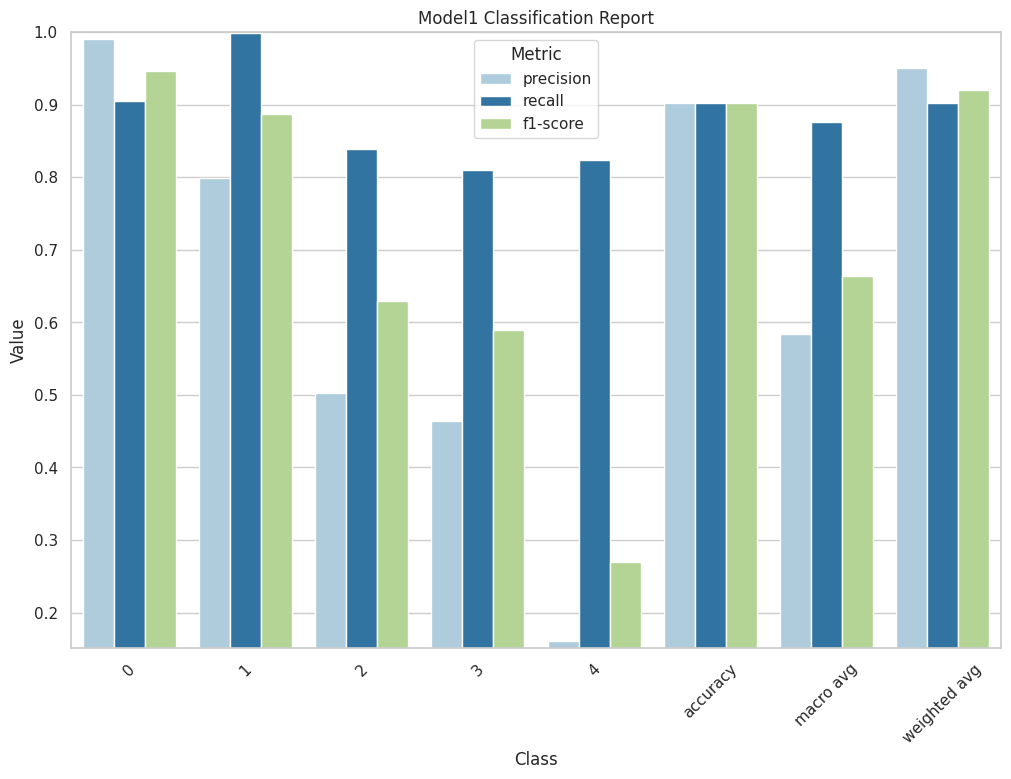


Model 1 evaluation for test dataset:
+--------------+-------------+----------+------------+--------------+
|              |   precision |   recall |   f1-score |      support |
+==============+=============+==========+============+==============+
| 0            |    0.990031 | 0.909999 |   0.948329 | 58388        |
+--------------+-------------+----------+------------+--------------+
| 1            |    0.798216 | 0.985593 |   0.882063 |  1180        |
+--------------+-------------+----------+------------+--------------+
| 2            |    0.529919 | 0.82605  |   0.645649 |  3570        |
+--------------+-------------+----------+------------+--------------+
| 3            |    0.485342 | 0.745    |   0.587771 |   200        |
+--------------+-------------+----------+------------+--------------+
| 4            |    0.15784  | 0.809524 |   0.264173 |   567        |
+--------------+-------------+----------+------------+--------------+
| accuracy     |    0.905297 | 0.905297 |   0.905297

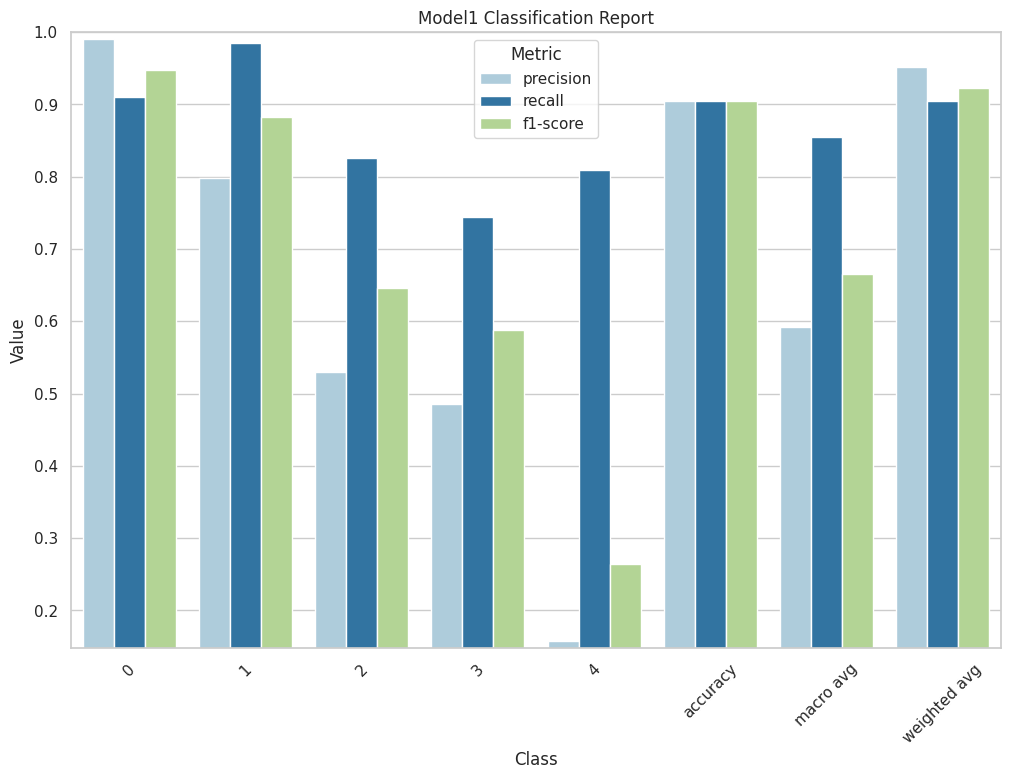

In [47]:
# Evaluate model #1
df_report_m1_train = evaluate(y_train,y_pred_train_m1,num_model=1,dataset="train")
df_report_m1_test = evaluate(y_test,y_pred_test_m1,num_model=1,dataset="test")

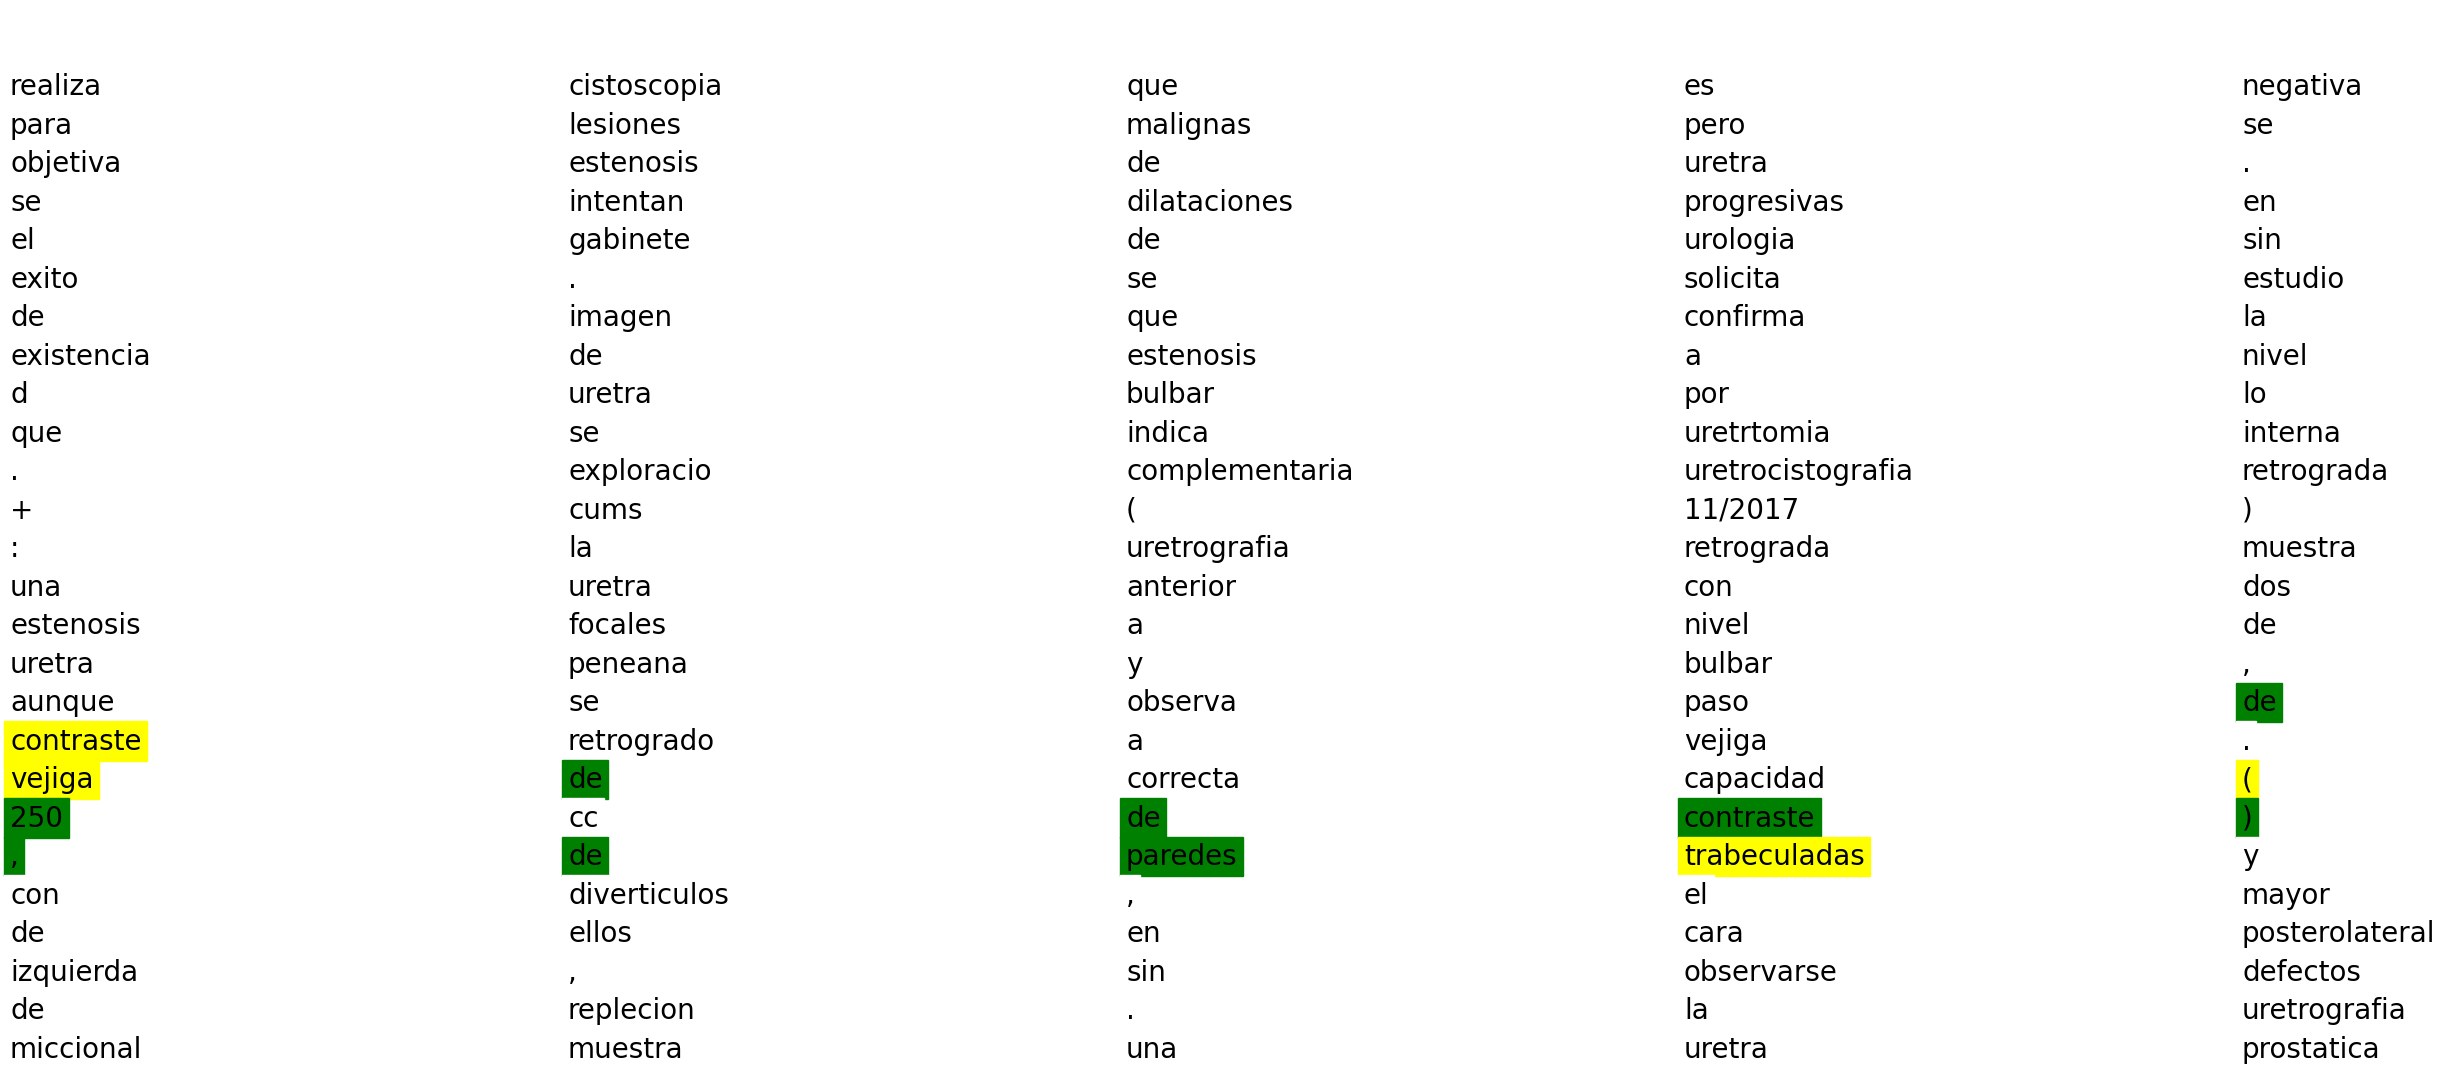

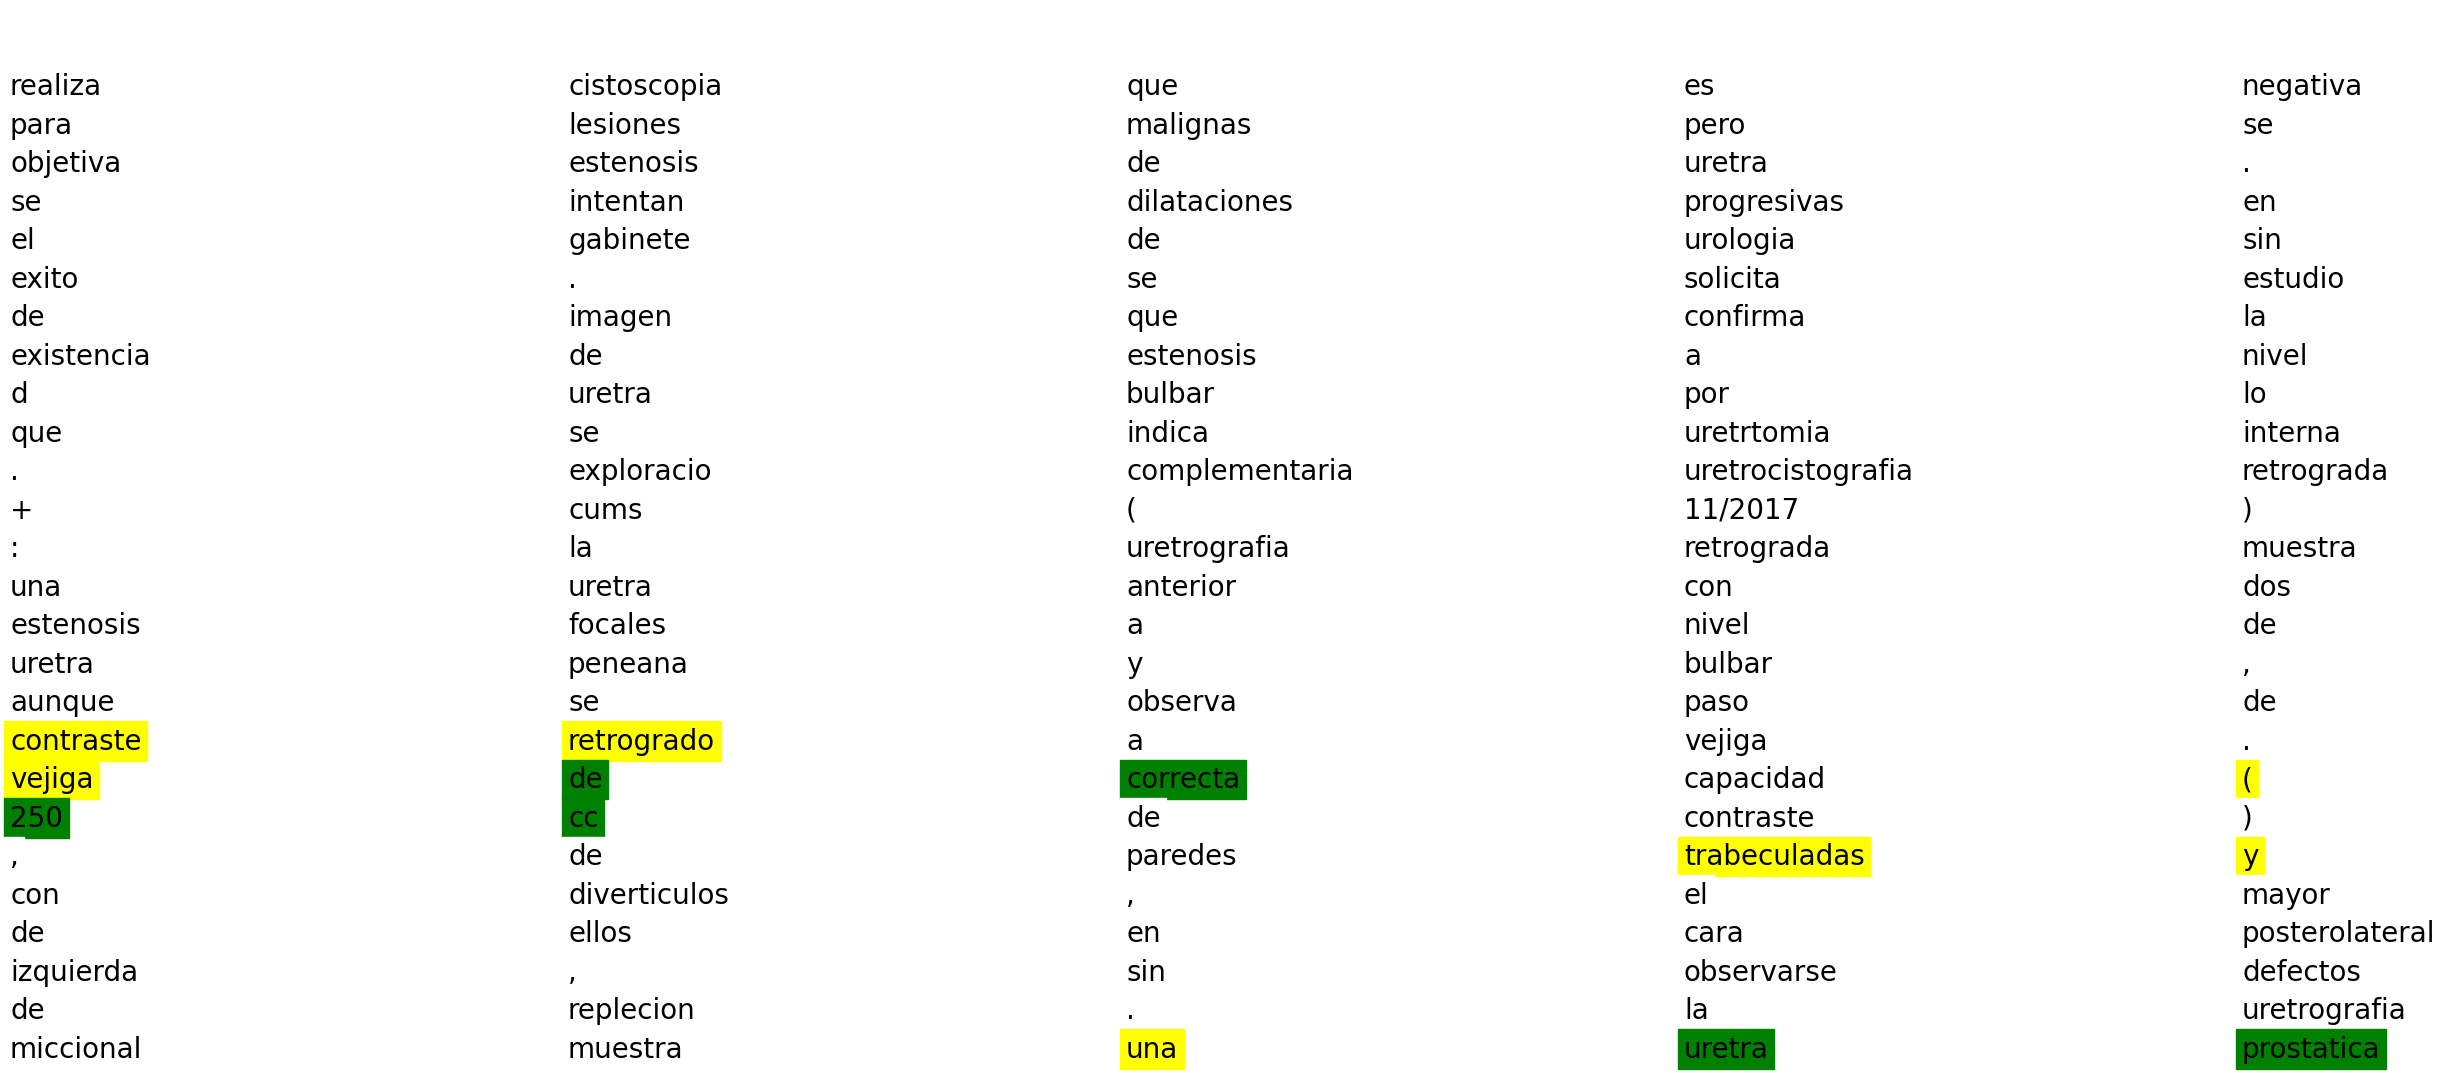

In [48]:
visualize_text_with_highlights(X_train_tokens[0][170:300],y_test[0][170:300])
visualize_text_with_highlights(X_train_tokens[0][170:300],y_pred_test_m1[0][170:300])

Results of model 2:


Model 2 evaluation for train dataset:
+--------------+-------------+----------+------------+--------------+
|              |   precision |   recall |   f1-score |      support |
+==============+=============+==========+============+==============+
| 0            |    0.935814 | 0.970311 |   0.952751 | 224531       |
+--------------+-------------+----------+------------+--------------+
| 1            |    0.885845 | 0.472437 |   0.616229 |   4517       |
+--------------+-------------+----------+------------+--------------+
| 2            |    0.400971 | 0.218511 |   0.28287  |  13981       |
+--------------+-------------+----------+------------+--------------+
| 3            |    0.523031 | 0.51462  |   0.518791 |    684       |
+--------------+-------------+----------+------------+--------------+
| 4            |    0.184372 | 0.202507 |   0.193015 |   2074       |
+--------------+-------------+----------+------------+--------------+
| accuracy     |    0.91065  | 0.91065  |   0.91065

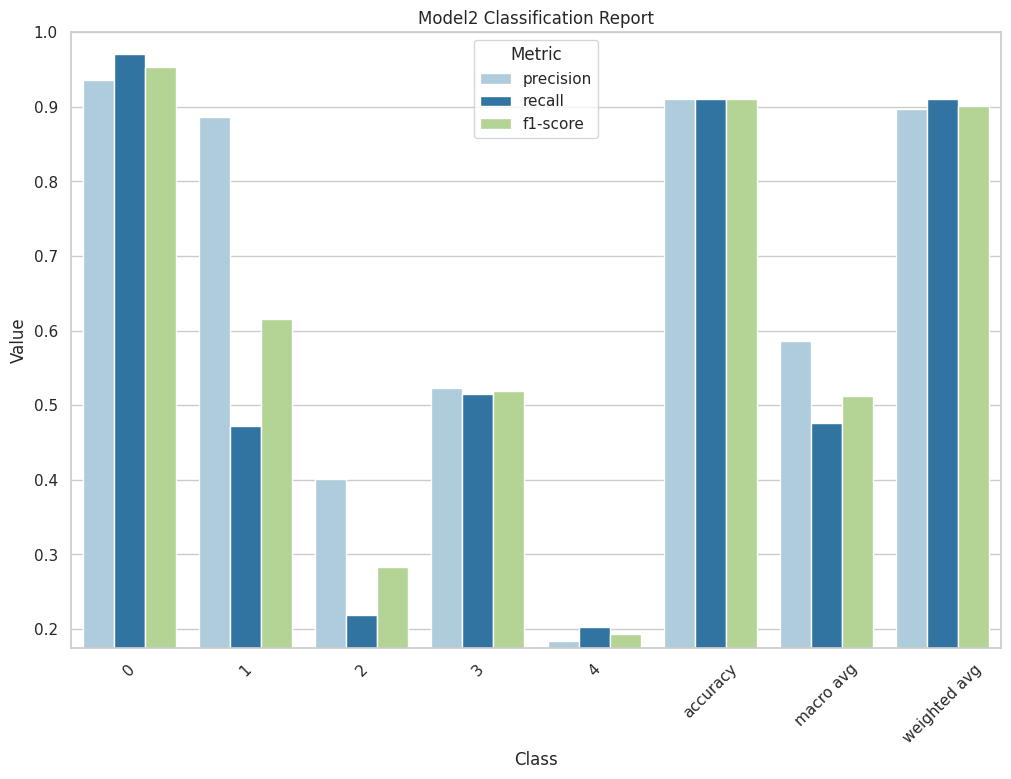


Model 2 evaluation for test dataset:
+--------------+-------------+----------+------------+--------------+
|              |   precision |   recall |   f1-score |      support |
+==============+=============+==========+============+==============+
| 0            |    0.935106 | 0.973847 |   0.954084 | 58388        |
+--------------+-------------+----------+------------+--------------+
| 1            |    0.911917 | 0.447458 |   0.600341 |  1180        |
+--------------+-------------+----------+------------+--------------+
| 2            |    0.418837 | 0.211765 |   0.281302 |  3570        |
+--------------+-------------+----------+------------+--------------+
| 3            |    0.527273 | 0.435    |   0.476712 |   200        |
+--------------+-------------+----------+------------+--------------+
| 4            |    0.209472 | 0.202822 |   0.206093 |   567        |
+--------------+-------------+----------+------------+--------------+
| accuracy     |    0.913027 | 0.913027 |   0.913027

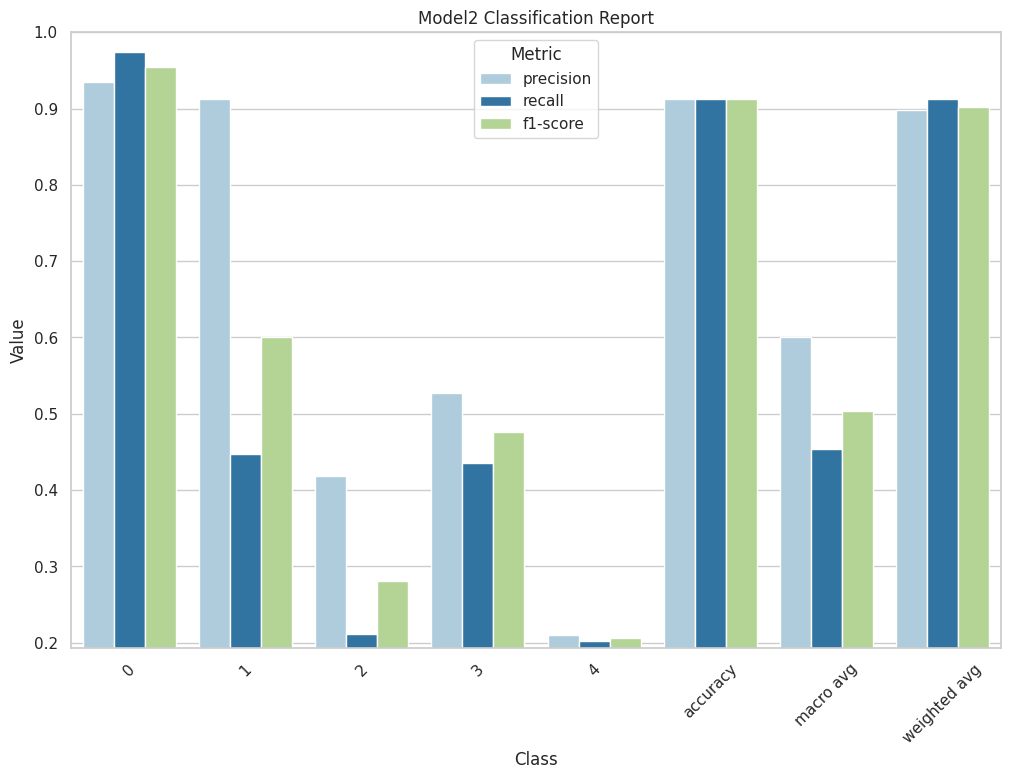

In [56]:
# Evaluate model #2
df_report_m2_train = evaluate(y_train,y_pred_train_m2,num_model=2,dataset="train")
df_report_m2_test = evaluate(y_test,y_pred_test_m2,num_model=2,dataset="test")

Results of model 3:


Model 3 evaluation for train dataset:
+--------------+-------------+----------+------------+---------------+
|              |   precision |   recall |   f1-score |       support |
+==============+=============+==========+============+===============+
| 0            |    0.942352 | 0.905162 |   0.923383 | 224531        |
+--------------+-------------+----------+------------+---------------+
| 1            |    0.824159 | 0.477308 |   0.604514 |   4517        |
+--------------+-------------+----------+------------+---------------+
| 2            |    0.232268 | 0.340319 |   0.276098 |  13981        |
+--------------+-------------+----------+------------+---------------+
| 3            |    0.524899 | 0.570175 |   0.546601 |    684        |
+--------------+-------------+----------+------------+---------------+
| 4            |    0.144747 | 0.437801 |   0.217563 |   2074        |
+--------------+-------------+----------+------------+---------------+
| accuracy     |    0.860294 | 0.86029

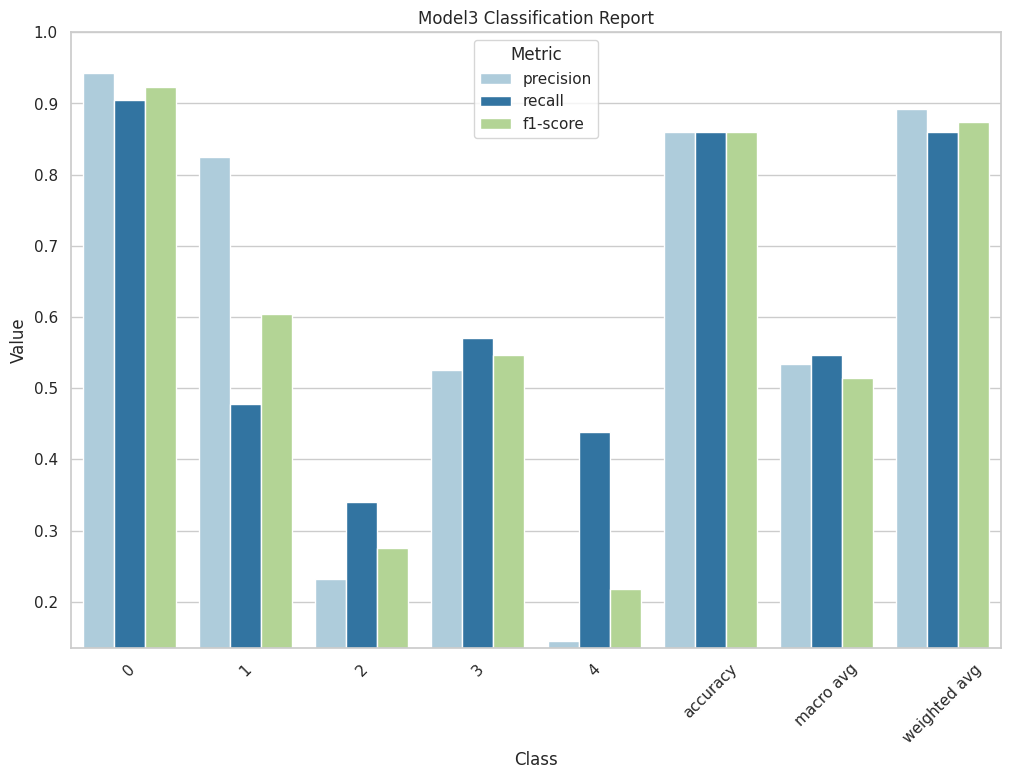


Model 3 evaluation for test dataset:
+--------------+-------------+----------+------------+--------------+
|              |   precision |   recall |   f1-score |      support |
+==============+=============+==========+============+==============+
| 0            |    0.943619 | 0.922416 |   0.932897 | 58388        |
+--------------+-------------+----------+------------+--------------+
| 1            |    0.829193 | 0.452542 |   0.585526 |  1180        |
+--------------+-------------+----------+------------+--------------+
| 2            |    0.286204 | 0.35098  |   0.315299 |  3570        |
+--------------+-------------+----------+------------+--------------+
| 3            |    0.532609 | 0.49     |   0.510417 |   200        |
+--------------+-------------+----------+------------+--------------+
| 4            |    0.155268 | 0.444444 |   0.230137 |   567        |
+--------------+-------------+----------+------------+--------------+
| accuracy     |    0.876223 | 0.876223 |   0.876223

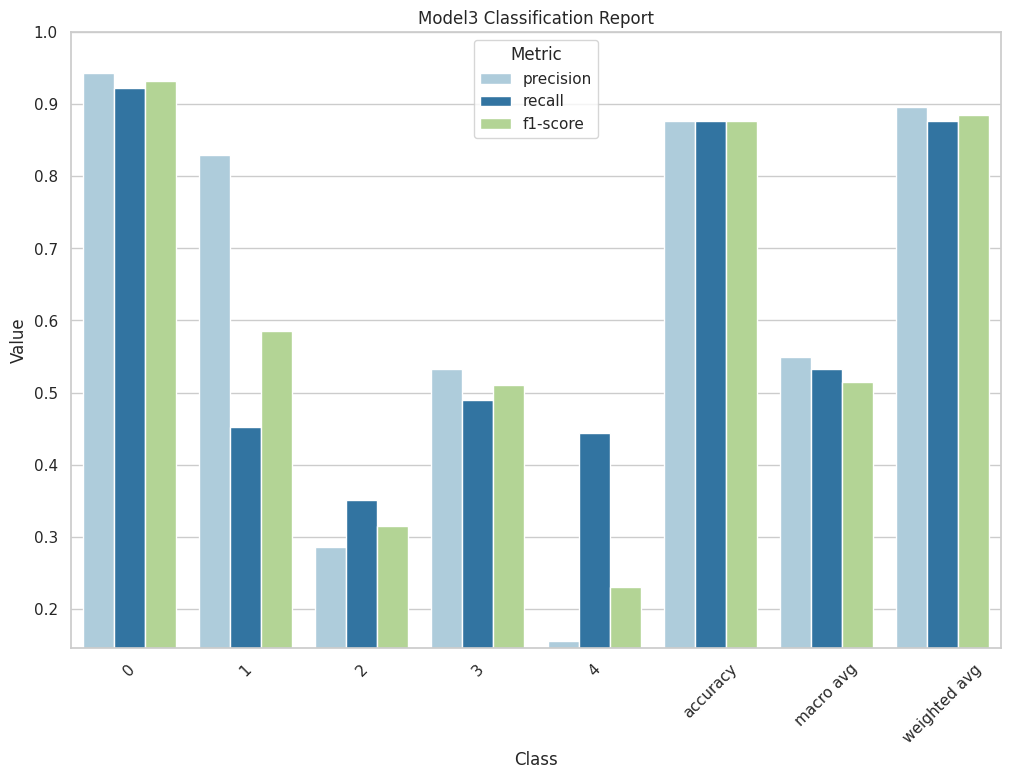

In [57]:
# Evaluate model #3
df_report_m3_train = evaluate(y_train,y_pred_train_m3,num_model=3,dataset="train")
df_report_m3_test = evaluate(y_test,y_pred_test_m3,num_model=3,dataset="test")

Comparison of all 3 models:

In [ ]:
# Show comparison for all models
train_metrics = {
    'Model 1': {'Accuracy': df_report_m1_train.loc['accuracy','support'],
                'Precision': df_report_m1_train.loc['macro avg','precision'],
                'Recall': df_report_m1_train.loc['macro avg','recall'],
                'F1-Score': df_report_m1_train.loc['macro avg','f1-score']},
    'Model 2': {'Accuracy': df_report_m2_train.loc['accuracy','support'],
                'Precision': df_report_m2_train.loc['macro avg','precision'],
                'Recall': df_report_m2_train.loc['macro avg','recall'],
                'F1-Score': df_report_m2_train.loc['macro avg','f1-score']},
    'Model 3': {'Accuracy': df_report_m3_train.loc['accuracy','support'],
                'Precision': df_report_m3_train.loc['macro avg','precision'],
                'Recall': df_report_m3_train.loc['macro avg','recall'],
                'F1-Score': df_report_m3_train.loc['macro avg','f1-score']}
}

test_metrics = {
    'Model 1': {'Accuracy': df_report_m1_test.loc['accuracy','support'],
                'Precision': df_report_m1_test.loc['macro avg','precision'],
                'Recall': df_report_m1_test.loc['macro avg','recall'],
                'F1-Score': df_report_m1_test.loc['macro avg','f1-score']},
    'Model 2': {'Accuracy': df_report_m2_test.loc['accuracy','support'],
                'Precision': df_report_m2_test.loc['macro avg','precision'],
                'Recall': df_report_m2_test.loc['macro avg','recall'],
                'F1-Score': df_report_m2_test.loc['macro avg','f1-score']},
    'Model 3': {'Accuracy': df_report_m3_test.loc['accuracy','support'],
                'Precision': df_report_m3_test.loc['macro avg','precision'],
                'Recall': df_report_m3_test.loc['macro avg','recall'],
                'F1-Score': df_report_m3_test.loc['macro avg','f1-score']}
}

# Convert metrics dictionaries to DataFrames
train_df = pd.DataFrame(train_metrics).transpose().reset_index().rename(columns={'index': 'Model'})
train_df['Set'] = 'Train'

test_df = pd.DataFrame(test_metrics).transpose().reset_index().rename(columns={'index': 'Model'})
test_df['Set'] = 'Test'

# Melt DataFrame to long format for Seaborn plot
train_df = pd.melt(train_df, id_vars=['Model', 'Set'], var_name='Metric', value_name='Value')
test_df = pd.melt(test_df, id_vars=['Model', 'Set'], var_name='Metric', value_name='Value')

# Plot using Seaborn
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Model', y='Value', hue='Metric', data=train_df, hue_order=['Accuracy', 'Precision', 'Recall', 'F1-Score'], palette='Paired')
plt.title('Metrics of Models on Train Sets')
plt.xlabel('Model')
plt.ylabel('Value')
plt.ylim(0, 1)
plt.legend(title='Metric', loc='upper left')
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')
plt.show()

plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Model', y='Value', hue='Metric', data=test_df, hue_order=['Accuracy', 'Precision', 'Recall', 'F1-Score'], palette='Paired')
plt.title('Metrics of Models on Test Sets')
plt.xlabel('Model')
plt.ylabel('Value')
plt.ylim(0, 1)
plt.legend(title='Metric', loc='upper left')
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')
plt.show()

Ground truth:


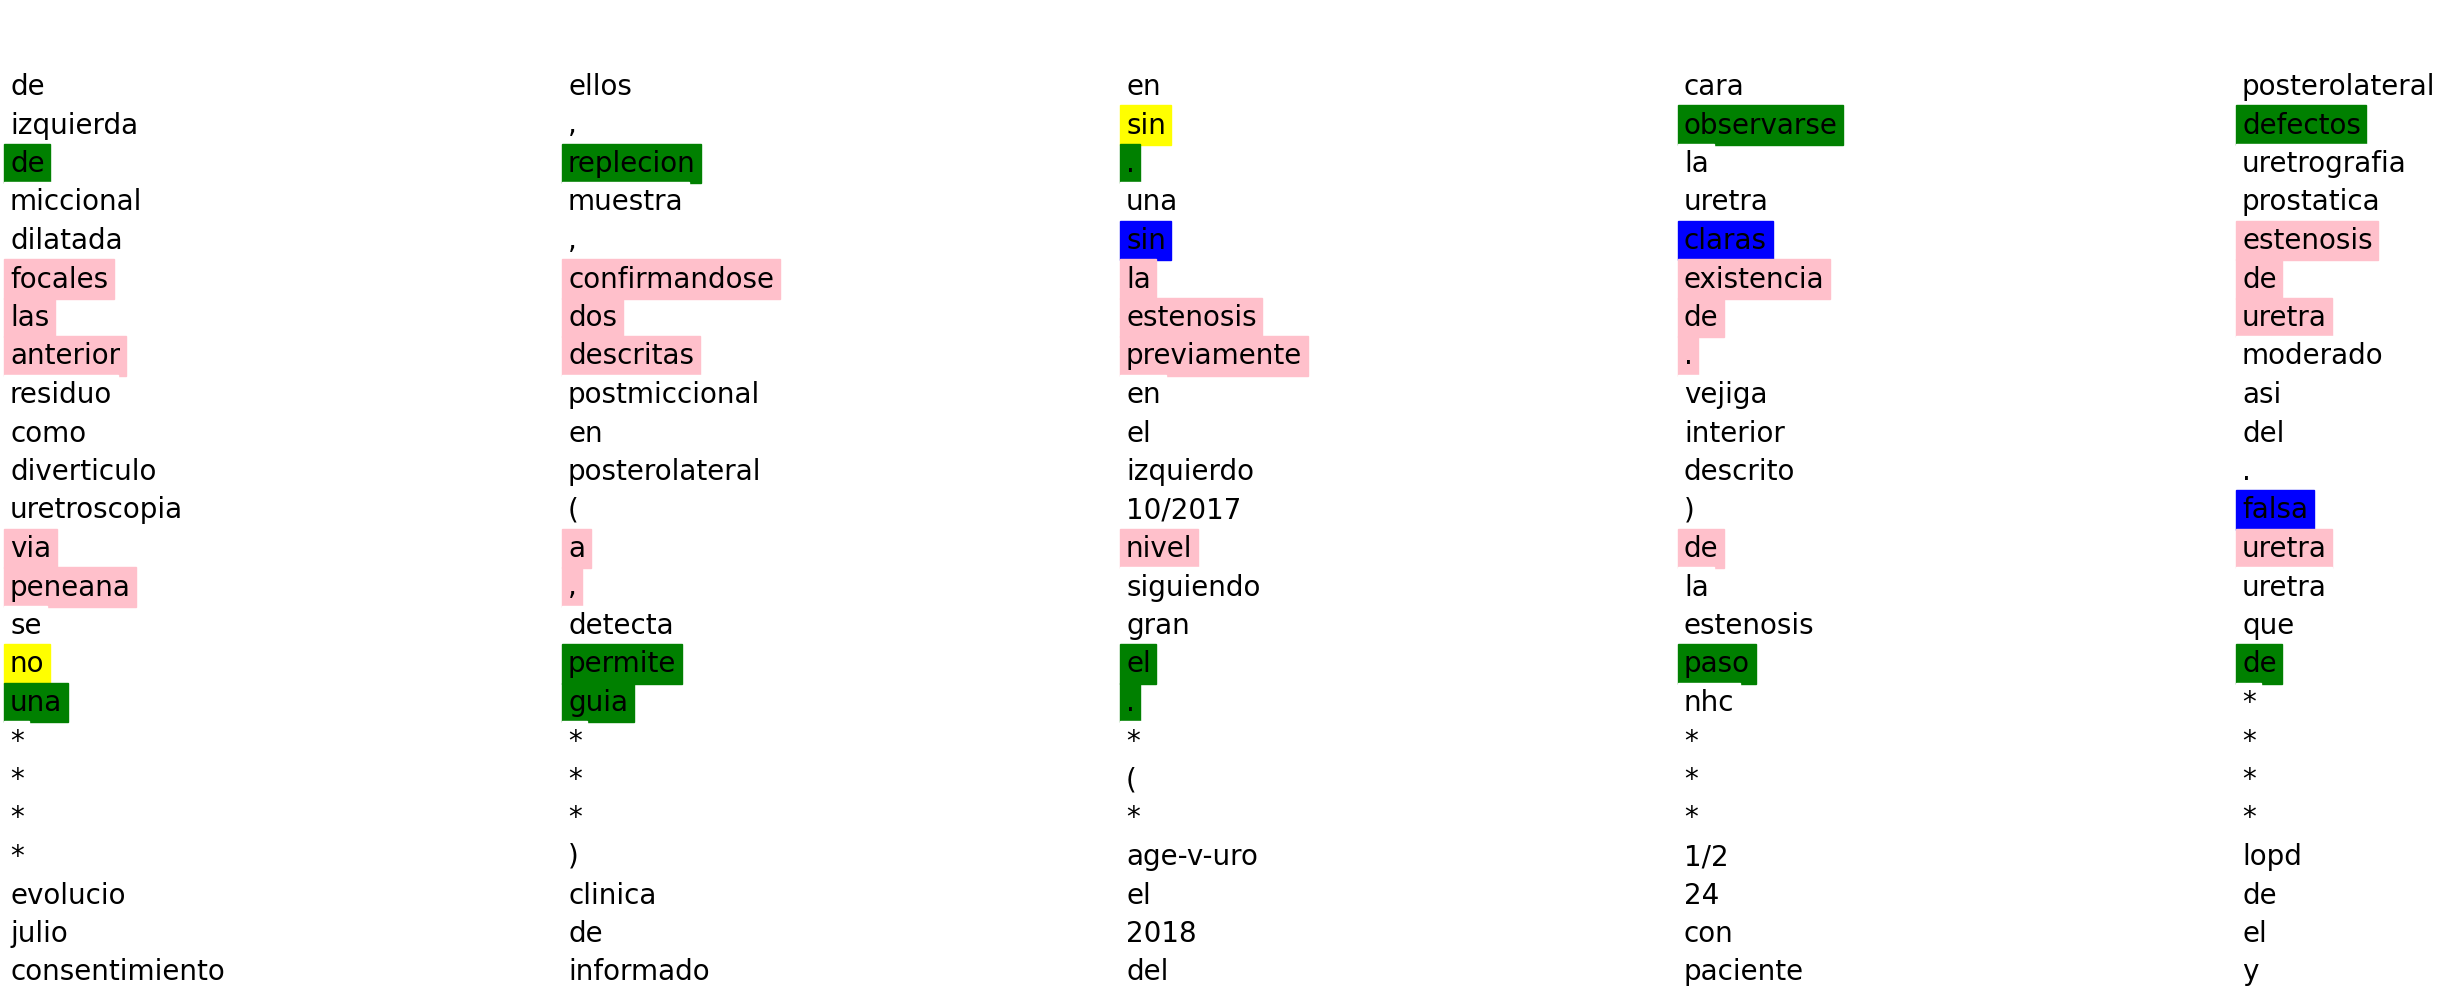

Model 1 output:


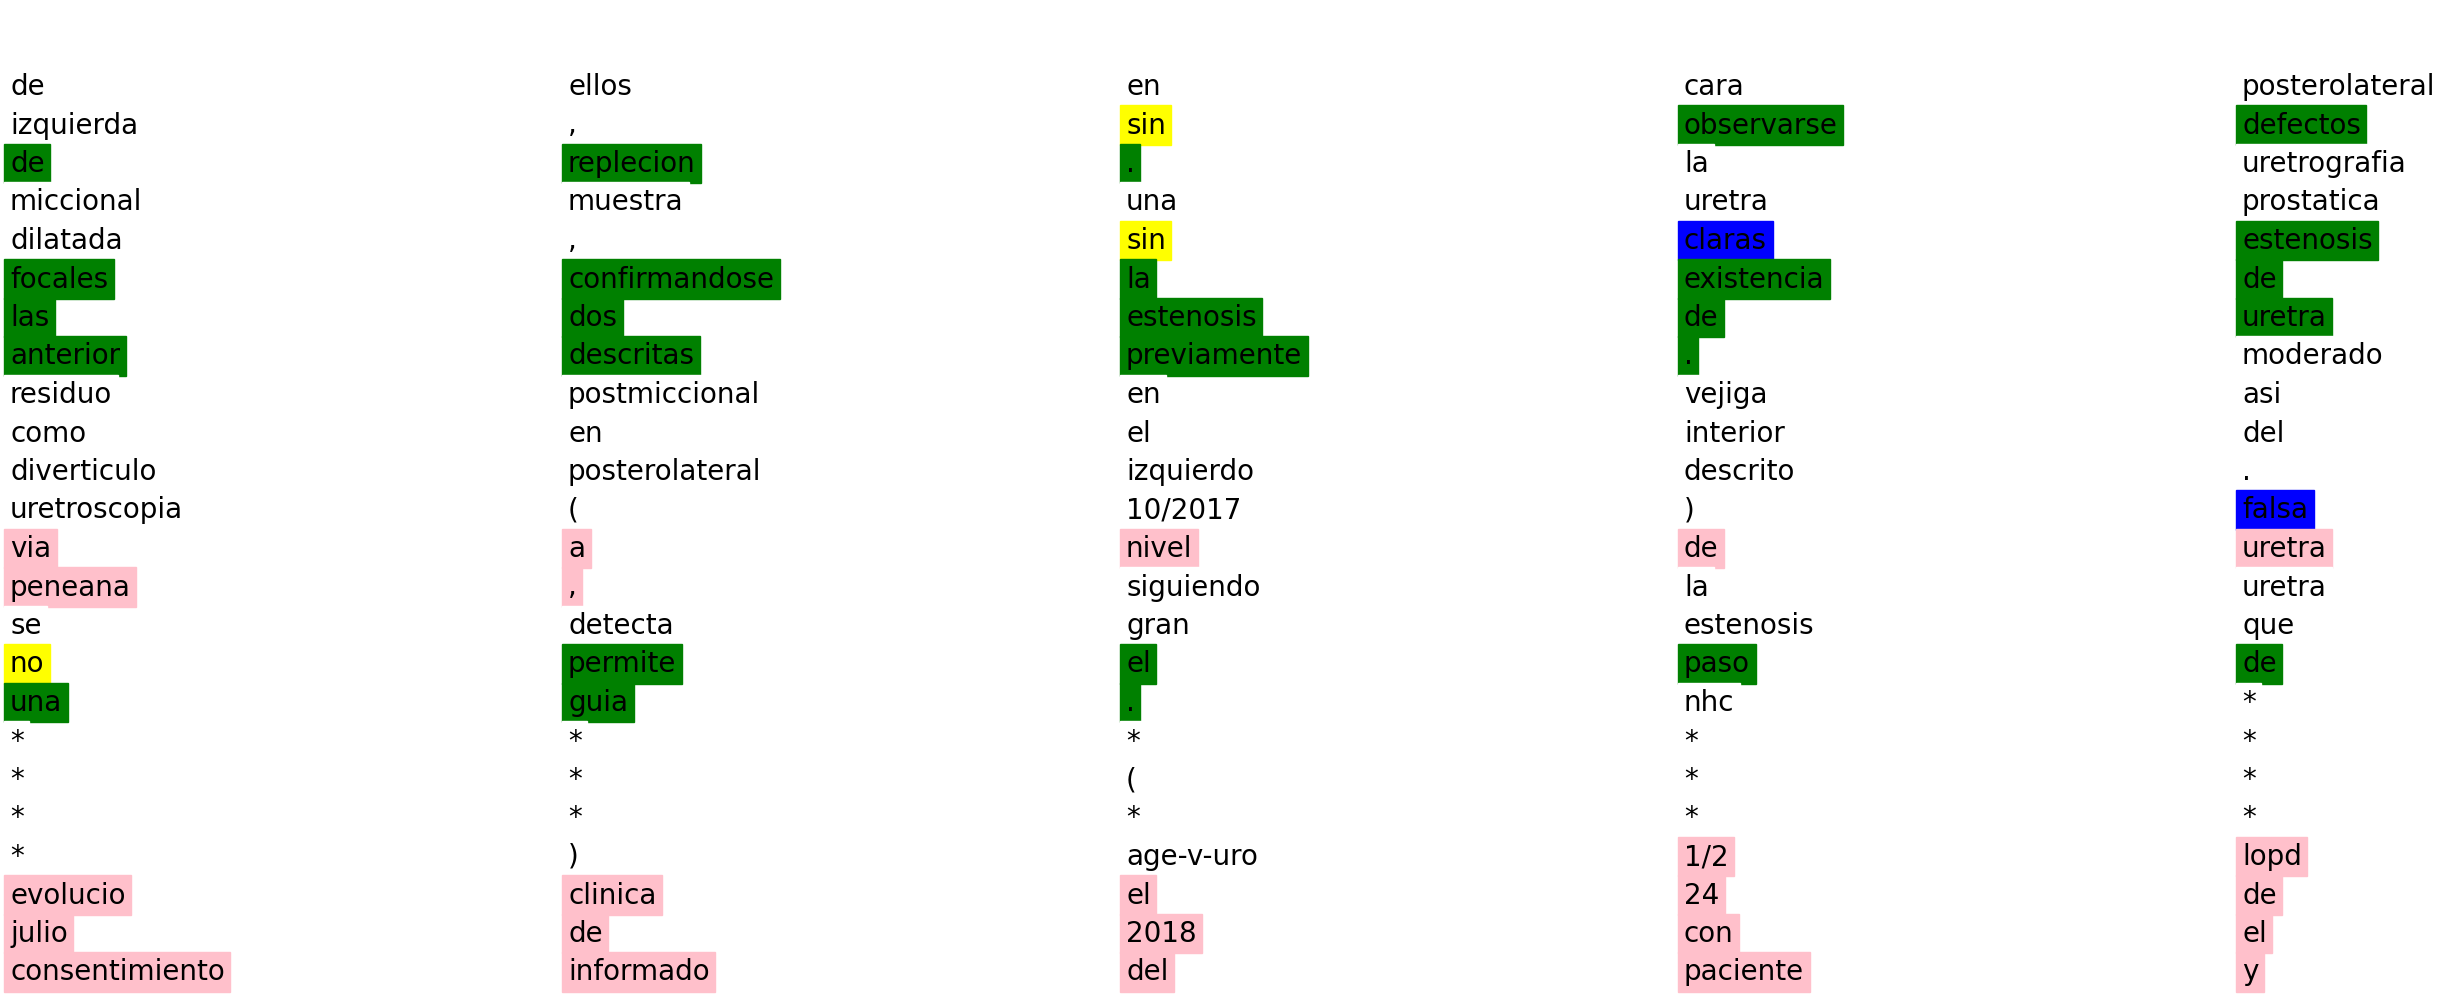

Model 2 output:


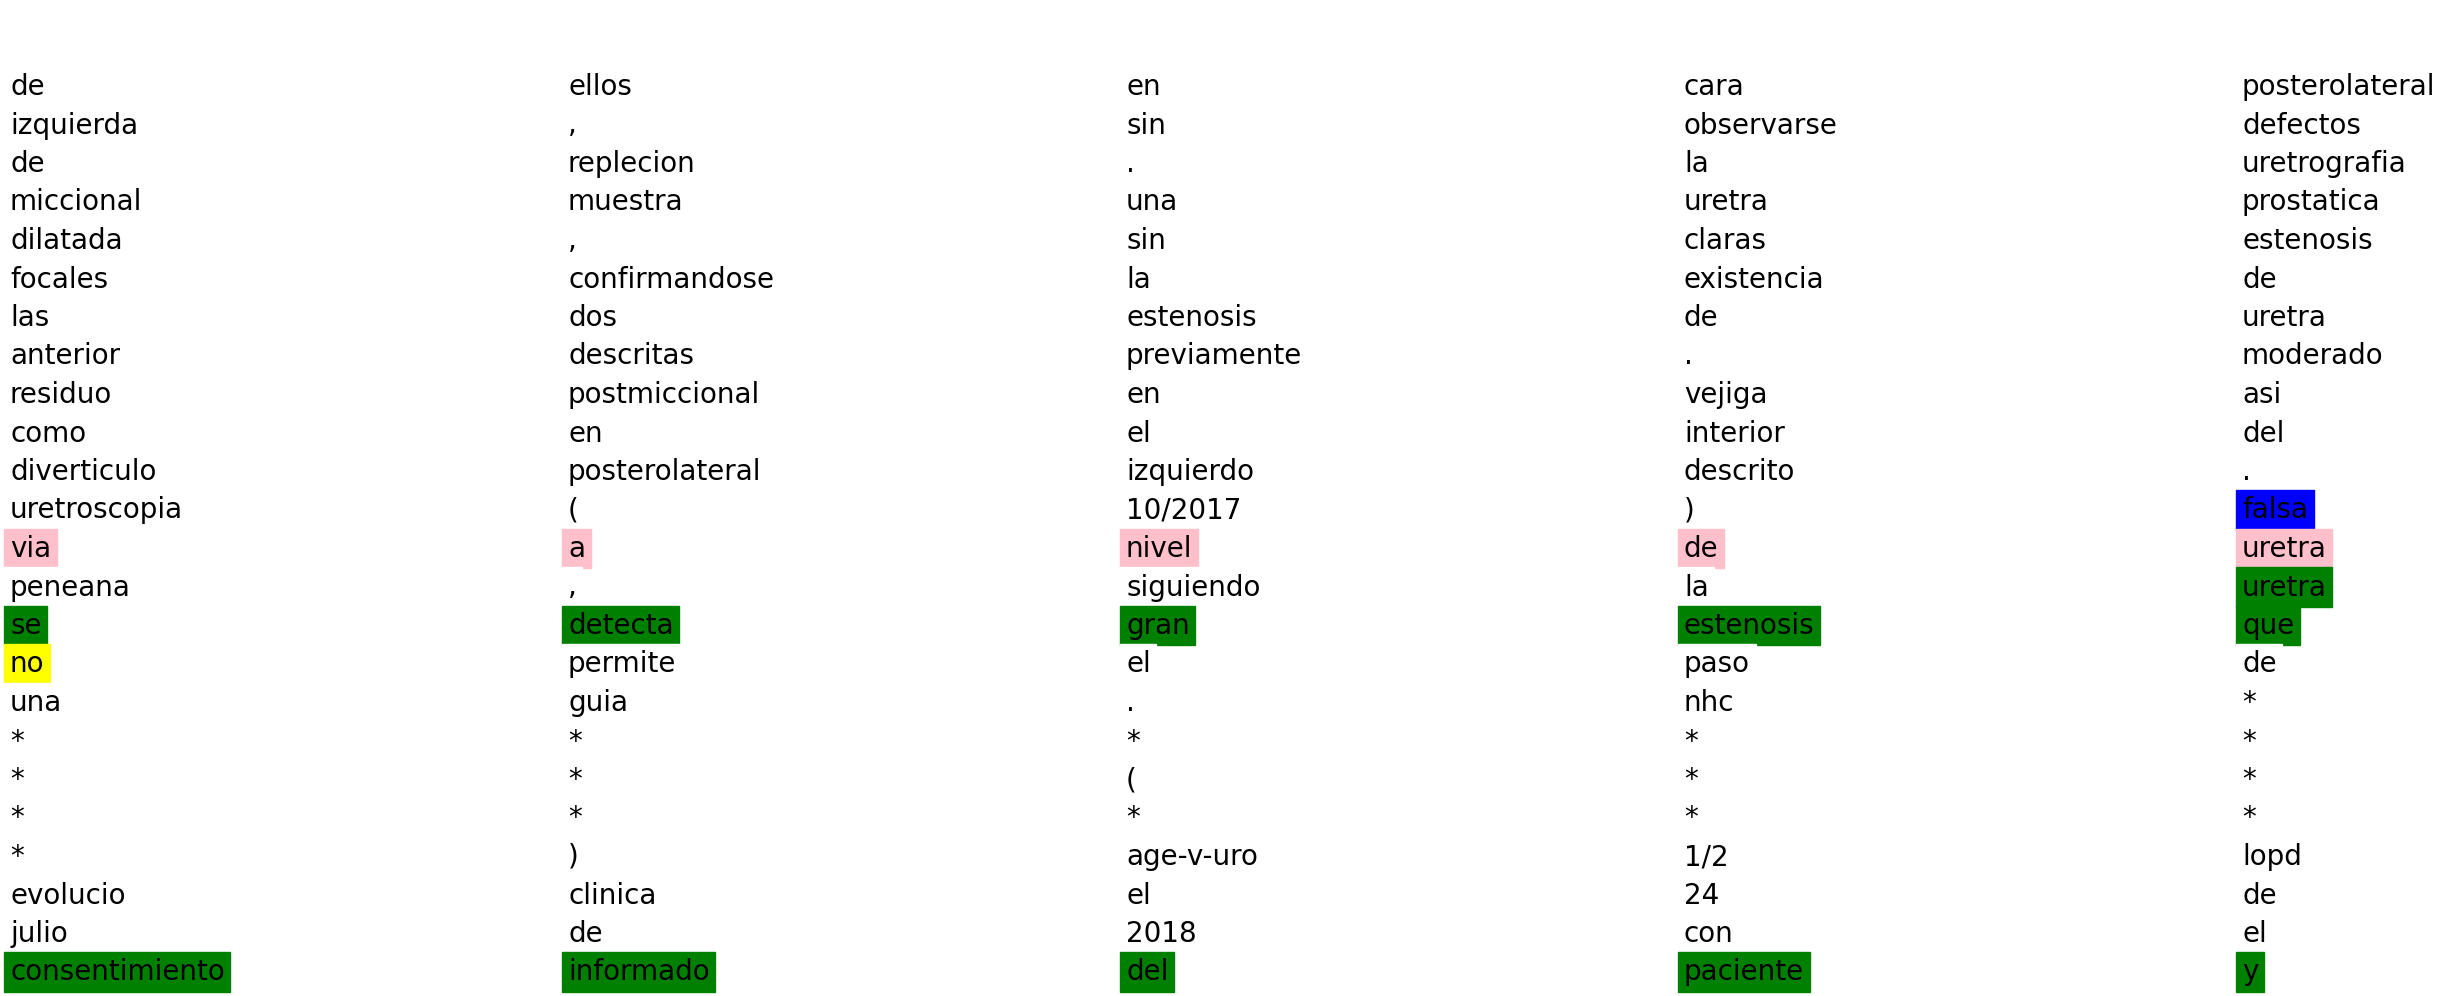

Model 3 output:


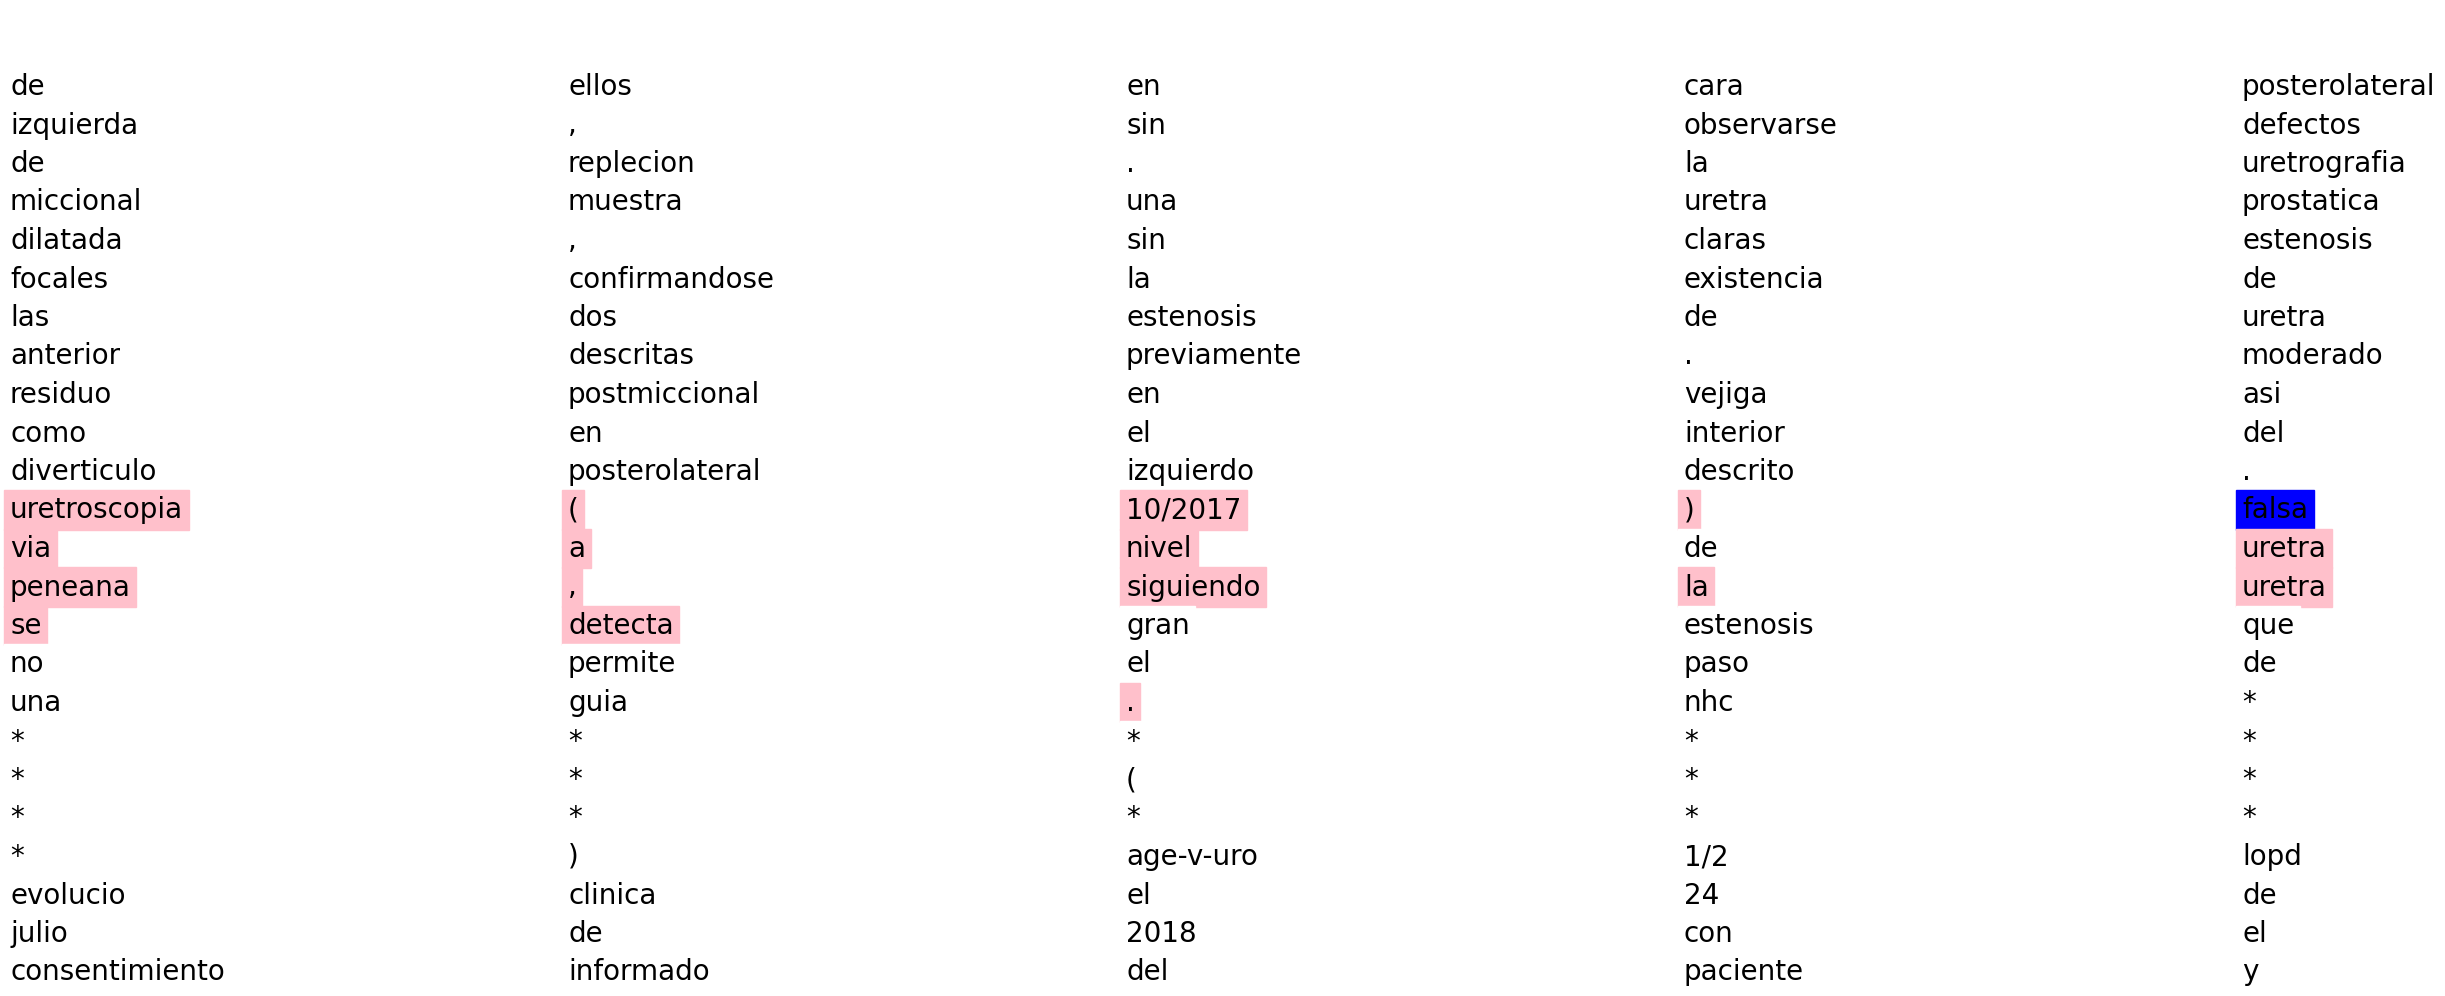

In [ ]:
# Sentences examples on training set
print("Ground truth:")
visualize_text_with_highlights(X_train_tokens[0][280:400],y_train[0][280:400])
print("Model 1 output:")
visualize_text_with_highlights(X_train_tokens[0][280:400],y_pred_train_m1[0][280:400])
print("Model 2 output:")
visualize_text_with_highlights(X_train_tokens[0][280:400],y_pred_train_m2[0][280:400])
print("Model 3 output:")
visualize_text_with_highlights(X_train_tokens[0][280:400],y_pred_train_m3[0][280:400])